In [37]:
from Bio import SeqIO
import pandas as pd
import numpy as np

from genominterv.remapping import remap
from genominterv.remapping import interval_distance, genomic
from genominterv.remapping import remap_interval_data
import seaborn as sns

Load file fasta fiel

In [38]:
columns = [
    "bin", "chrom", "chromStart", "chromEnd", "name", "score", "strand",
    "thickStart", "thickEnd", "reserved", "blockCount", "blockSizes",
    "chromStarts", "strandRep", "repLeft", "repClass", "repFamily"
]

simple_repeats =pd.read_csv("../data/simpleRepeat.txt", sep='\t', header=None, names=columns)
simple_repeats = simple_repeats[simple_repeats['chrom'] == 'chrX']
print(simple_repeats.head(10))
df_simple_repeats = simple_repeats[['chrom', 'chromStart', 'chromEnd']].rename(
    columns={'chromStart': 'start', 'chromEnd': 'end'}
)
print(simple_repeats['repFamily'].unique().shape)

        bin chrom  chromStart  chromEnd name  score  strand  thickStart  \
935331  585  chrX        1329      1368  trf     20     1.9          20   
935332  585  chrX        4721      4765  trf     16     2.8          16   
935333  585  chrX        4722      5839  trf    354     3.1         361   
935334  585  chrX        4767      4806  trf     20     2.0          20   
935335  585  chrX        4783      4826  trf     16     2.7          16   
935336  585  chrX        4789      4937  trf      4    37.2           4   
935337  585  chrX        4857      4905  trf     19     2.5          20   
935338  585  chrX        5057      5127  trf     32     2.2          32   
935339  585  chrX        5073      5883  trf      4   203.8           4   
935340  585  chrX        5788      6005  trf     20    11.1          20   

        thickEnd  reserved  blockCount  blockSizes  chromStarts  strandRep  \
935331        89         5          60          79            0         15   
935332        78  

### functions that kasper made to use to hamdel the compartment edges

In [39]:
def parse_compartment_data(file_name):
    e1_100kb = pd.read_csv(file_name)
    e1_100kb['start'] = [i*100_000 for i in range(e1_100kb.index.size)]
    e1_100kb['end'] = e1_100kb.start + 100_000
    e1_100kb['sign'] = np.sign(e1_100kb.e1)
    e1_100kb['segment_id'] = ((e1_100kb.sign.shift() != e1_100kb.sign)).cumsum()
    
    comp = e1_100kb.groupby('segment_id', as_index=False).agg(dict(
         e1=['mean', 'sum'], 
         start='min', 
         end='max', 
         segment_id='mean', 
         sign='mean'
    ))
    comp.columns = ['_'.join(col).strip() for col in comp.columns.values]
    comp = comp.rename(
        columns={'start_min':'start',
                 'end_max':'end', 
                 'segment_id_mean':'segment_id', 
                 'sign_mean':'sign'}
    )
    comp['comp'] = ['A' if x > 0 else 'B' for x in comp.sign]
    comp = comp.reset_index()
    comp['chrom'] = 'chrX'
    
    _comp = comp.copy()
    for i in range(1, _comp.index.size-1):
        if np.isnan(_comp.loc[i-1, 'e1_mean']):
            _comp.loc[i, 'start'] = np.nan
        if np.isnan(_comp.loc[i+1, 'e1_mean']):
            _comp.loc[i, 'end'] = np.nan
    _comp = _comp.loc[~_comp.e1_mean.isnull(), :]
    _comp = _comp.reset_index()
    compartment_edges = pd.concat([_comp.start, _comp.end]).sort_values().unique()
    
    compartments = comp.loc[~comp.e1_mean.isnull()].copy()
    compartments['start'] = compartments.start.astype(int)
    compartments['end'] = compartments.end.astype(int)

    return compartments, compartment_edges

def edge_segments(compartment_edges, flank):
    compartment_edge_segm = pd.DataFrame(np.column_stack((compartment_edges, compartment_edges+flank)), columns=['start', 'end'])
    compartment_edge_segm['chrom'] = 'chrX'
    return compartment_edge_segm

### loading the 5 eigentracks 

In [40]:
import os

# Load data
eigentrack_dir = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/eigentracks"
eigentrack_files = [
    f for f in os.listdir(eigentrack_dir) if f.endswith("_10Mb.csv")
]

comps_dict = {}
edges_dict = {}
generated_comps=[]
generated_edges=[]
a_and_b_comps = []

for filename in eigentrack_files:
    filepath = os.path.join(eigentrack_dir, filename)
    base = os.path.splitext(filename)[0]
    comps_var = f"{base}_comps"
    edges_var = f"{base}_edges"
    comps, edges = parse_compartment_data(filepath)
    comps_dict[comps_var] = comps
    edges_dict[edges_var] = edges
    generated_comps.append(comps_var)
    generated_edges.append(edges_var)

print("Generated variable names:", generated_comps)
print("Generated variable names:", generated_edges)

for edge_var in generated_edges:
    # Get the numpy array of edges from the dictionary
    edges = edges_dict[edge_var]
    
    # Create the DataFrame using edge_segments with flank=1
    seg_name = f"{edge_var}_interval"
    seg_df = edge_segments(edges, 1)
    #print(f"Created: {seg_name}")

    # Merge compartment assignment
    comps_var = edge_var.replace("_edges", "_comps")
    if comps_var in comps_dict:
        comps_df = comps_dict[comps_var]
        
        comp_df = pd.DataFrame({
            'comp': comps_df['comp'].reset_index(drop=True),
            'start': seg_df['start'].reset_index(drop=True),
            'end': seg_df['end'].reset_index(drop=True),
            'chrom': seg_df['chrom'].reset_index(drop=True)
        })

        # Save full merged comp_df
        comp_full_name = f"{edge_var}_interval_comp"
            # Save combined A and B compartments
        comp_AB_name = f"{edge_var}_AB"
        globals()[comp_AB_name] = comp_df
        a_and_b_comps.append(comp_AB_name)

        #print(f"Created: {comp_full_name}")

        # Split into compartments A and B
        comp_A = comp_df[comp_df['comp'] == 'A'].reset_index(drop=True)
        comp_B = comp_df[comp_df['comp'] == 'B'].reset_index(drop=True)

        # Save A and B splits as new variables
        comp_A_name = f"{edge_var}_A"
        comp_B_name = f"{edge_var}_B"
        globals()[comp_A_name] = comp_A
        globals()[comp_B_name] = comp_B
        a_and_b_comps.append(comp_A_name)
        a_and_b_comps.append(comp_B_name)
        
        #print(f"Created: {edge_var}_A and {edge_var}_B")

print("Generated compartment A and B variables:", a_and_b_comps)

#print(sperm_e1_100kb_10Mb_edges_A.head())

print(globals()[comp_AB_name].head())


Generated variable names: ['sperm_e1_100kb_10Mb_comps', 'round_spermatid_e1_100kb_10Mb_comps', 'pachytene_spermatocyte_e1_100kb_10Mb_comps', 'spermatogonia_e1_100kb_10Mb_comps', 'fibroblast_e1_100kb_10Mb_comps']
Generated variable names: ['sperm_e1_100kb_10Mb_edges', 'round_spermatid_e1_100kb_10Mb_edges', 'pachytene_spermatocyte_e1_100kb_10Mb_edges', 'spermatogonia_e1_100kb_10Mb_edges', 'fibroblast_e1_100kb_10Mb_edges']
Generated compartment A and B variables: ['sperm_e1_100kb_10Mb_edges_AB', 'sperm_e1_100kb_10Mb_edges_A', 'sperm_e1_100kb_10Mb_edges_B', 'round_spermatid_e1_100kb_10Mb_edges_AB', 'round_spermatid_e1_100kb_10Mb_edges_A', 'round_spermatid_e1_100kb_10Mb_edges_B', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_AB', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_A', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_B', 'spermatogonia_e1_100kb_10Mb_edges_AB', 'spermatogonia_e1_100kb_10Mb_edges_A', 'spermatogonia_e1_100kb_10Mb_edges_B', 'fibroblast_e1_100kb_10Mb_edges_AB', 'fibroblast_e1_1

In [41]:
for edge_var in generated_edges:
    comp_AB_name = f"{edge_var}_AB"
    if comp_AB_name in globals():
        print(f"Head of {comp_AB_name}:")
        print(globals()[comp_AB_name].head())
        print()



Head of sperm_e1_100kb_10Mb_edges_AB:
  comp       start         end chrom
0    A   2500000.0   2500001.0  chrX
1    A   8300000.0   8300001.0  chrX
2    A   9800000.0   9800001.0  chrX
3    A  10000000.0  10000001.0  chrX
4    B  10400000.0  10400001.0  chrX

Head of round_spermatid_e1_100kb_10Mb_edges_AB:
  comp      start        end chrom
0    A  7900000.0  7900001.0  chrX
1    A  8000000.0  8000001.0  chrX
2    A  8400000.0  8400001.0  chrX
3    B  8500000.0  8500001.0  chrX
4    A  8900000.0  8900001.0  chrX

Head of pachytene_spermatocyte_e1_100kb_10Mb_edges_AB:
  comp       start         end chrom
0    A   9000000.0   9000001.0  chrX
1    A   9100000.0   9100001.0  chrX
2    B   9800000.0   9800001.0  chrX
3    A  10000000.0  10000001.0  chrX
4    B  10500000.0  10500001.0  chrX

Head of spermatogonia_e1_100kb_10Mb_edges_AB:
  comp       start         end chrom
0    A   9700000.0   9700001.0  chrX
1    A  10000000.0  10000001.0  chrX
2    B  10100000.0  10100001.0  chrX
3    A  

#### remapping the compartment edges

In [42]:
# Drop rows with missing start/end first
sperm_clean = sperm_e1_100kb_10Mb_edges_AB.dropna(subset=["start", "end"]).copy()

# Convert to regular integer type
sperm_clean["start"] = sperm_clean["start"].astype(int)
sperm_clean["end"] = sperm_clean["end"].astype(int)
print(sperm_clean.head(10))

# Proceed with remapping
result = remap_interval_data(df_simple_repeats, sperm_clean, include_prox_coord=True)

# Post-processing
result["mid"] = (result["start"] + result["end"]) / 2
result["absmid"] = result["mid"].abs()

# Replace zeros with NaN
for col in ["start", "end", "mid", "absmid"]:
    result[col] = result[col].replace([0.0, -0.0], np.nan)

# Drop rows where all are NaN
result = result.dropna(subset=["start", "end", "mid", "absmid"], how="all")

print(result.head())
print(result.shape)






  comp     start       end chrom
0    A   2500000   2500001  chrX
1    A   8300000   8300001  chrX
2    A   9800000   9800001  chrX
3    A  10000000  10000001  chrX
4    B  10400000  10400001  chrX
5    A  10800000  10800001  chrX
6    B  11000000  11000001  chrX
7    A  12400000  12400001  chrX
8    B  13200000  13200001  chrX
9    A  13300000  13300001  chrX
     start      end  start_prox  end_prox chrom  start_orig  end_orig  \
0 -2498632 -2498671         NaN       NaN  chrX        1329      1368   
1 -2495235 -2495279         NaN       NaN  chrX        4721      4765   
2 -2494161 -2495278         NaN       NaN  chrX        4722      5839   
3 -2495194 -2495233         NaN       NaN  chrX        4767      4806   
4 -2495174 -2495217         NaN       NaN  chrX        4783      4826   

         mid     absmid  
0 -2498651.5  2498651.5  
1 -2495257.0  2495257.0  
2 -2494719.5  2494719.5  
3 -2495213.5  2495213.5  
4 -2495195.5  2495195.5  
(53826, 9)


In [43]:
print(sperm_e1_100kb_10Mb_edges_AB.head(10))

result = remap_interval_data(df_simple_repeats, sperm_e1_100kb_10Mb_edges_AB, include_prox_coord=True)

# Post-processing
result["mid"] = (result["start"] + result["end"]) / 2
result["absmid"] = result["mid"].abs()

# Replace zeros with NaN
for col in ["start", "end", "mid", "absmid"]:
    result[col] = result[col].replace([0.0, -0.0], np.nan)

# Drop rows where all are NaN
result = result.dropna(subset=["start", "end", "mid", "absmid"], how="all")

print(result.head())
print(result.shape)

  comp       start         end chrom
0    A   2500000.0   2500001.0  chrX
1    A   8300000.0   8300001.0  chrX
2    A   9800000.0   9800001.0  chrX
3    A  10000000.0  10000001.0  chrX
4    B  10400000.0  10400001.0  chrX
5    A  10800000.0  10800001.0  chrX
6    B  11000000.0  11000001.0  chrX
7    A  12400000.0  12400001.0  chrX
8    B  13200000.0  13200001.0  chrX
9    A  13300000.0  13300001.0  chrX
       start        end  start_prox  end_prox chrom  start_orig  end_orig  \
0 -2498632.0 -2498671.0         NaN       NaN  chrX        1329      1368   
1 -2495235.0 -2495279.0         NaN       NaN  chrX        4721      4765   
2 -2494161.0 -2495278.0         NaN       NaN  chrX        4722      5839   
3 -2495194.0 -2495233.0         NaN       NaN  chrX        4767      4806   
4 -2495174.0 -2495217.0         NaN       NaN  chrX        4783      4826   

         mid     absmid  
0 -2498651.5  2498651.5  
1 -2495257.0  2495257.0  
2 -2494719.5  2494719.5  
3 -2495213.5  2495213.5  


In [44]:
df_simple_repeats.head(10)

,chrom,start,end
935331,chrX,1329,1368
935332,chrX,4721,4765
935333,chrX,4722,5839
935334,chrX,4767,4806
935335,chrX,4783,4826
935336,chrX,4789,4937
935337,chrX,4857,4905
935338,chrX,5057,5127
935339,chrX,5073,5883
935340,chrX,5788,6005


In [45]:
# def assign_closest_edge_and_split(result, edge_df):
#     edges = edge_df['start'].dropna().values

#     def find_closest_edge(val, edges):
#         return edges[np.argmin(np.abs(edges - val))] if len(edges) > 0 else np.nan

#     result['closest_edge'] = result['start_orig'].apply(lambda x: find_closest_edge(x, edges))
#     result['signed_dist'] = result['start_orig'] - result['closest_edge']

#     A_value = result[
#         ((result['comp'] == 'A') & (result['signed_dist'] < 0)) |
#         ((result['comp'] == 'B') & (result['signed_dist'] > 0))
#     ].reset_index(drop=True)

#     B_value = result[
#         ((result['comp'] == 'A') & (result['signed_dist'] > 0)) |
#         ((result['comp'] == 'B') & (result['signed_dist'] < 0))
#     ].reset_index(drop=True)

#     return A_value, B_value

# # Example usage:
# A_value, B_value = assign_closest_edge_and_split(result, sperm_e1_100kb_10Mb_edges_AB)
# print(A_value.head())
# print(B_value.head())

In [46]:

result = remap_interval_data(sperm_e1_100kb_10Mb_edges_AB,df_simple_repeats)
result["mid"] = (result["start"] + result["end"]) / 2
result["absmid"] = result["mid"].abs()
for col in ['start', 'end', 'mid', 'absmid']:
    result[col] = result[col].replace([0.0, -0.0], np.nan)
    # Remove rows where all of these columns are NaN
result = result.dropna(subset=['start', 'end', 'mid', 'absmid'], how='all')
#print(result.head())

# Define conditions
A_value = result[
    ((result['comp'] == 'A') & (result['start'] < 0)) |
    ((result['comp'] == 'B') & (result['start'] > 0))
].reset_index(drop=True)

B_value = result[
    ((result['comp'] == 'A') & (result['start'] > 0)) |
    ((result['comp'] == 'B') & (result['start'] < 0))
].reset_index(drop=True)
print(A_value.head())
print(B_value.head())
print(A_value.shape)
print(B_value.shape)

    start     end comp  start_orig    end_orig chrom     mid  absmid
0  -390.0  -391.0    A   2500000.0   2500001.0  chrX  -390.5   390.5
1  -368.0  -369.0    A   8300000.0   8300001.0  chrX  -368.5   368.5
2 -1834.0 -1835.0    A   9800000.0   9800001.0  chrX -1834.5  1834.5
3  -852.0  -853.0    A  10800000.0  10800001.0  chrX  -852.5   852.5
4   -90.0   -91.0    A  12400000.0  12400001.0  chrX   -90.5    90.5
    start     end comp  start_orig    end_orig chrom     mid  absmid
0  1373.0  1374.0    A  10000000.0  10000001.0  chrX  1373.5  1373.5
1 -2042.0 -2043.0    B  10400000.0  10400001.0  chrX -2042.5  2042.5
2 -3201.0 -3202.0    B  11000000.0  11000001.0  chrX -3201.5  3201.5
3 -4196.0 -4197.0    B  13200000.0  13200001.0  chrX -4196.5  4196.5
4  -900.0  -901.0    B  15700000.0  15700001.0  chrX  -900.5   900.5
(73, 8)
(53, 8)


In [47]:
df_simple_repeats.head()

,chrom,start,end
935331,chrX,1329,1368
935332,chrX,4721,4765
935333,chrX,4722,5839
935334,chrX,4767,4806
935335,chrX,4783,4826


In [48]:
# Step 1: Remap
result = remap_interval_data(df_simple_repeats, sperm_e1_100kb_10Mb_edges_AB)

# Step 2: Merge the compartment label based on 'start_orig' and 'chrom'
comp_df = sperm_e1_100kb_10Mb_edges_AB[['start', 'comp', 'chrom']]
comp_df.rename(columns={'start': 'start_orig'}, inplace=True)  # match result column

result = result.merge(comp_df, on=['start_orig', 'chrom'], how='left')

/tmp/ipykernel_3025406/2953870491.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.rename(columns={'start': 'start_orig'}, inplace=True)  # match result column


In [49]:
import numpy as np
import pandas as pd
from genominterv.remapping import remap_interval_data
df_simple_repeats = simple_repeats[['chrom', 'chromStart', 'chromEnd']].rename(
    columns={'chromStart': 'start', 'chromEnd': 'end'}
)


def remap_and_split_compartments(repeats_df, comp_df):
    """
    Remap repeats to compartments, compute midpoints, clean 0.0/-0.0,
    and split result into A_value and B_value based on compartment logic.
    
    Parameters:
        repeats_df (pd.DataFrame): Repeat intervals (must include 'start', 'end', 'chrom')
        comp_df (pd.DataFrame): Compartment intervals (must include 'start', 'end', 'chrom', 'comp')
    
    Returns:
        A_value (pd.DataFrame): Rows where compartment alignment matches expected
        B_value (pd.DataFrame): Rows where compartment alignment is flipped
    """
    # Remap
    result = remap_interval_data(repeats_df, comp_df)

    # Add midpoint features
    result["mid"] = (result["start"] + result["end"]) / 2
    result["absmid"] = result["mid"].abs()


    # Replace 0.0 and -0.0 with NaN
    for col in ['start', 'end', 'mid', 'absmid']:
        result[col] = result[col].replace([0.0, -0.0], np.nan)

    # Drop rows where all key coordinate columns are NaN
    result = result.dropna(subset=['start', 'end', 'mid', 'absmid'], how='all')

    # Split based on logic
    A_value = result[
        ((result['comp'] == 'A') & (result['start'] < 0)) |
        ((result['comp'] == 'B') & (result['start'] > 0))
    ].reset_index(drop=True)

    B_value = result[
        ((result['comp'] == 'A') & (result['start'] > 0)) |
        ((result['comp'] == 'B') & (result['start'] < 0))
    ].reset_index(drop=True)

    return A_value, B_value

A_val, B_val = remap_and_split_compartments(sperm_e1_100kb_10Mb_edges_AB, df_simple_repeats)
print(A_val.head())
print(B_val.head())

    start     end comp  start_orig    end_orig chrom     mid  absmid
0  -390.0  -391.0    A   2500000.0   2500001.0  chrX  -390.5   390.5
1  -368.0  -369.0    A   8300000.0   8300001.0  chrX  -368.5   368.5
2 -1834.0 -1835.0    A   9800000.0   9800001.0  chrX -1834.5  1834.5
3  -852.0  -853.0    A  10800000.0  10800001.0  chrX  -852.5   852.5
4   -90.0   -91.0    A  12400000.0  12400001.0  chrX   -90.5    90.5
    start     end comp  start_orig    end_orig chrom     mid  absmid
0  1373.0  1374.0    A  10000000.0  10000001.0  chrX  1373.5  1373.5
1 -2042.0 -2043.0    B  10400000.0  10400001.0  chrX -2042.5  2042.5
2 -3201.0 -3202.0    B  11000000.0  11000001.0  chrX -3201.5  3201.5
3 -4196.0 -4197.0    B  13200000.0  13200001.0  chrX -4196.5  4196.5
4  -900.0  -901.0    B  15700000.0  15700001.0  chrX  -900.5   900.5


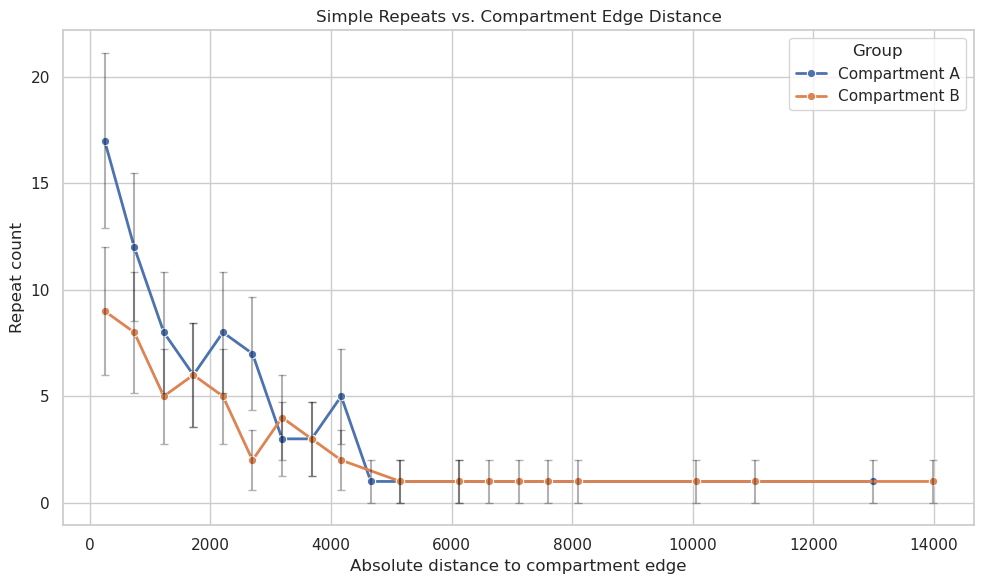

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add group labels and abs(start)
A_val['abs_start'] = A_val['start'].abs()
B_val['abs_start'] = B_val['start'].abs()
A_val['group'] = 'Compartment A'
B_val['group'] = 'Compartment B'

# Combine
plot_df = pd.concat([A_val[['abs_start', 'group']], B_val[['abs_start', 'group']]])

# Create bins
bins = np.linspace(0, plot_df['abs_start'].max(), 30)
plot_df['bin'] = pd.cut(plot_df['abs_start'], bins, labels=False)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Count per bin and group
binned = plot_df.groupby(['group', 'bin']).size().reset_index(name='count')
binned['bin_center'] = binned['bin'].apply(lambda i: bin_centers[int(i)] if pd.notna(i) else np.nan)
binned['error'] = np.sqrt(binned['count'])

# Plot
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.lineplot(data=binned, x='bin_center', y='count', hue='group', marker='o', linewidth=2)

# Add Poisson error bars manually
for _, row in binned.iterrows():
    plt.errorbar(row['bin_center'], row['count'], yerr=row['error'], fmt='none', capsize=3, color='black', alpha=0.3)

# Labels and final touches
plt.xlabel('Absolute distance to compartment edge')
plt.ylabel('Repeat count')
plt.title('Simple Repeats vs. Compartment Edge Distance')
plt.legend(title='Group')
plt.tight_layout()
plt.show()


### fixing error bars

In [51]:
import numpy as np

def bin_half_distances(comp, max_dist=2_000_000, bins=20):
    start = comp['start'].values
    # Compute half-distances between consecutive start positions
    half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]

    # Bin those distances
    bin_edges = np.linspace(0, max_dist, bins + 1)
    counts, _ = np.histogram(half_distances, bins=bin_edges)

    # Reverse cumulative sum — how many possible contributing edges for each bin
    reverse_cumulative_counts = np.cumsum(counts[::-1])[::-1]

    return counts, reverse_cumulative_counts


## Ah shit it did not save

Function to run simple repeat where we split into a and b compartment

In [52]:
import numpy as np
import pandas as pd
from genominterv.remapping import remap_interval_data

def plot_repeat_density_vs_compartment_edge(df_repeats, df_compartment_anchors):
    """
    Remaps repeat intervals to a compartment coordinate space and returns the
    A-value and B-value groups based on signed distance logic.

    Parameters:
    - df_repeats: DataFrame of genomic intervals to remap (must have chrom/start/end).
    - df_compartment_anchors: DataFrame with compartment structure (must have chrom/start/end/comp).

    Returns:
    - A_val: DataFrame for Compartment A-assigned intervals
    - B_val: DataFrame for Compartment B-assigned intervals
    """

    # Clean and sort
    sperm_clean = df_compartment_anchors.dropna(subset=["start", "end"]).copy()
    sperm_clean["start"] = sperm_clean["start"].astype(int)
    sperm_clean["end"] = sperm_clean["end"].astype(int)
    df_repeats = df_repeats.dropna(subset=["start", "end"]).copy()
    df_repeats["start"] = df_repeats["start"].astype(int)
    df_repeats["end"] = df_repeats["end"].astype(int)

    # Sort
    sperm_clean = sperm_clean.sort_values(by=['chrom', 'start', 'end'])
    df_repeats = df_repeats.sort_values(by=['chrom', 'start', 'end'])

    # Remap
    result = remap_interval_data(df_repeats, sperm_clean, include_prox_coord=True)

    # Post-process
    result["mid"] = (result["start"] + result["end"]) / 2
    result["absmid"] = result["mid"].abs()
    for col in ["start", "end", "mid", "absmid"]:
        result[col] = result[col].replace([0.0, -0.0], np.nan)
    result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")

    # Map compartment identity
    start_to_comp = sperm_clean.drop_duplicates(subset=["start"]).set_index("start")["comp"]
    result["comp"] = result["start_prox"].map(start_to_comp)

    # Split into A and B groups based on signed start
    A_val = result[
        ((result['comp'] == 'A') & (result['start'] < 0)) |
        ((result['comp'] == 'B') & (result['start'] > 0))
    ].copy()
    B_val = result[
        ((result['comp'] == 'A') & (result['start'] > 0)) |
        ((result['comp'] == 'B') & (result['start'] < 0))
    ].copy()

    # Add abs start and label
    A_val['abs_start'] = A_val['start'].abs()
    B_val['abs_start'] = B_val['start'].abs()
    A_val['group'] = 'Compartment A'
    B_val['group'] = 'Compartment B'

    return A_val, B_val


In [53]:
ab_dfs = {name: obj for name, obj in globals().items()
          if name.endswith('_AB') and isinstance(obj, pd.DataFrame)}
remapped_simple_filter_data = {}

for name, df_anchor in ab_dfs.items():
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = plot_repeat_density_vs_compartment_edge(df_simple_repeats, df_anchor)
        remapped_simple_filter_data[name.replace('_AB', '')] = {"A": A_value, "B": B_value}
        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")



Running on: sperm_e1_100kb_10Mb_edges_AB
  A_value: (23604, 12), B_value: (24102, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
  A_value: (23796, 12), B_value: (22331, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (26912, 12), B_value: (16810, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (19781, 12), B_value: (25581, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (31452, 12), B_value: (19375, 12)


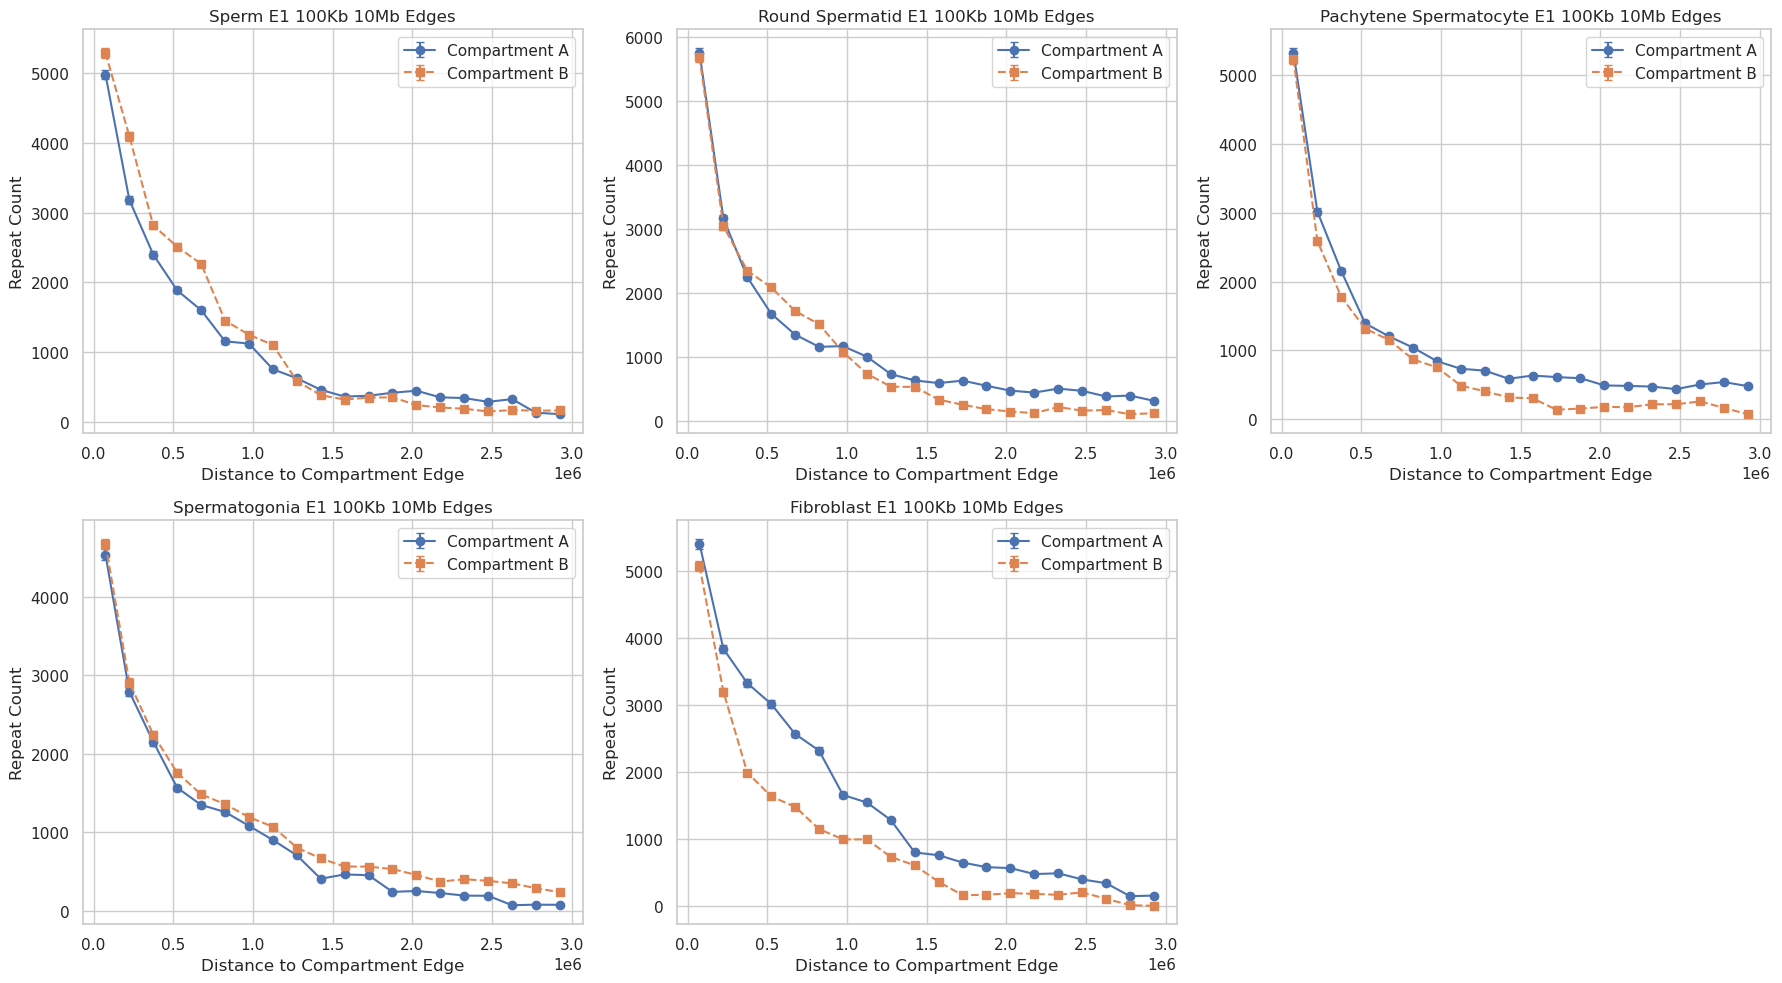

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Plot settings
# num_bins = 20
# max_dist = 3_000_000
# bins = np.linspace(0, max_dist, num_bins + 1)
# bin_centers = 0.5 * (bins[:-1] + bins[1:])

# def bin_absmid_with_error(absmid_values, bins):
#     counts, _ = np.histogram(absmid_values, bins=bins)
#     errors = np.sqrt(counts)
#     return counts, errors

# # Prepare plot grid
# fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# axes = axes.flatten()

# # Loop through samples
# for idx, (sample, pair) in enumerate(remapped_simple_filter_data.items()):
#     A_df = pair["A"]
#     B_df = pair["B"]

#     # Bin 'absmid'
#     counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins)
#     counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins)

#     ax = axes[idx]
#     ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
#     ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
#     ax.set_title(sample.replace("_", " ").title())
#     ax.set_xlabel("Distance to Compartment Edge")
#     ax.set_ylabel("Repeat Count")
#     ax.grid(True)
#     ax.legend()

# # Hide unused subplot (slot 6)
# if len(remapped_simple_filter_data) < len(axes):
#     for i in range(len(remapped_simple_filter_data), len(axes)):
#         axes[i].axis('off')

# plt.tight_layout()
# plt.show()



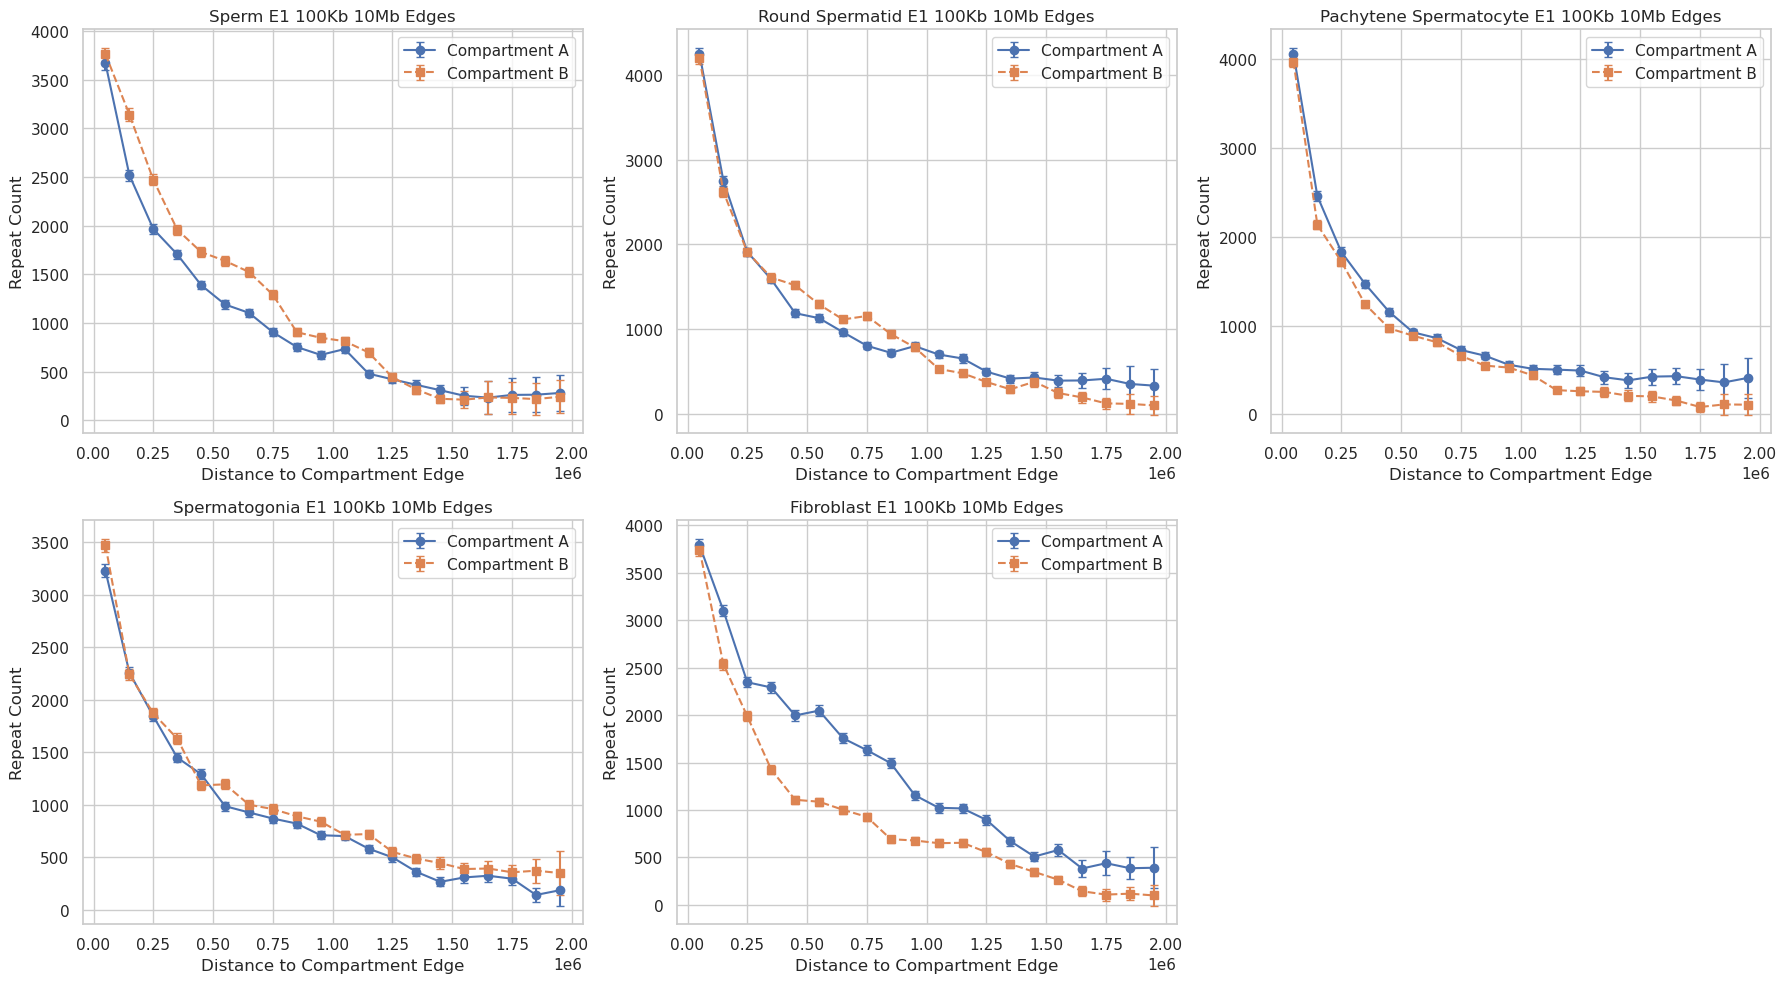

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_absmid_with_error(absmid_values, bins, edge_reverse_cumulative):
    counts, _ = np.histogram(absmid_values, bins=bins)

    # Regular Poisson errors
    errors = np.sqrt(counts)

    # Avoid division by zero
    edge_reverse_cumulative = np.where(edge_reverse_cumulative == 0, 1, edge_reverse_cumulative)

    # Adjust errors based on how many edges contribute to each bin
    adjusted_errors = errors * (1 + 10 / edge_reverse_cumulative)

    return counts, adjusted_errors



# Prepare plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plotting
for idx, (sample, pair) in enumerate(remapped_simple_filter_data.items()):
    A_df = pair["A"]
    B_df = pair["B"]
    # Get the actual edge DataFrame using the sample name
    edge_df = globals()[sample+ "_AB"]  # assumes sperm_e1_... etc. are loaded variables

    # Compute edge spacing reverse cumulative
    edges_counts, edges_reverse_cumulative = bin_half_distances(edge_df)
    counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins, edges_reverse_cumulative)
    counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins, edges_reverse_cumulative)

    ax = axes[idx]
    ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
    ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
    ax.set_title(sample.replace("_", " ").title())
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True)
    ax.legend()

# Hide unused subplot (slot 6)
if len(remapped_simple_filter_data) < len(axes):
    for i in range(len(remapped_simple_filter_data), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()

simple repeat we only look at transtition arears ab og ba

In [56]:
def remapping_no_filter_compartment(df_repeats, df_compartment_anchors):
    """
    Remaps repeats to compartment edges and groups only by target compartment identity,
    ignoring directionality. Returns absolute distances for plotting.

    Parameters:
    - df_repeats: DataFrame with columns chrom, start, end
    - df_compartment_anchors: DataFrame with columns chrom, start, end, comp

    Returns:
    - A_val: DataFrame of repeats near compartment A
    - B_val: DataFrame of repeats near compartment B
    """
    # Clean and sort
    anchors = df_compartment_anchors.dropna(subset=["start", "end"]).copy()
    anchors["start"] = anchors["start"].astype(int)
    anchors["end"] = anchors["end"].astype(int)
    df_repeats = df_repeats.dropna(subset=["start", "end"]).copy()
    df_repeats["start"] = df_repeats["start"].astype(int)
    df_repeats["end"] = df_repeats["end"].astype(int)

    anchors = anchors.sort_values(by=['chrom', 'start', 'end'])
    df_repeats = df_repeats.sort_values(by=['chrom', 'start', 'end'])

    # Remap
    result = remap_interval_data(df_repeats, anchors, include_prox_coord=True)

    # Post-process
    result["mid"] = (result["start"] + result["end"]) / 2
    result["absmid"] = result["mid"].abs()
    result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")

    # Map compartment identity
    start_to_comp = anchors.drop_duplicates(subset=["start"]).set_index("start")["comp"]
    result["comp"] = result["start_prox"].map(start_to_comp)

    # Split only based on target compartment (ignore direction)
    A_val = result[result['comp'] == 'A'].copy()
    B_val = result[result['comp'] == 'B'].copy()

    A_val["abs_start"] = A_val["start"].abs()
    B_val["abs_start"] = B_val["start"].abs()
    A_val["group"] = "Compartment A"
    B_val["group"] = "Compartment B"

    return A_val, B_val



In [57]:
ab_dfs = {name: obj for name, obj in globals().items()
          if name.endswith('_AB') and isinstance(obj, pd.DataFrame)}
remapped_data = {}

for name, df_anchor in ab_dfs.items():
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = remapping_no_filter_compartment(df_simple_repeats, df_anchor)
        remapped_data[name.replace('_AB', '')] = {"A": A_value, "B": B_value}
        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")


Running on: sperm_e1_100kb_10Mb_edges_AB


  A_value: (24708, 12), B_value: (22998, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
  A_value: (17811, 12), B_value: (28316, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (22615, 12), B_value: (21107, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (24082, 12), B_value: (21280, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (21746, 12), B_value: (29081, 12)


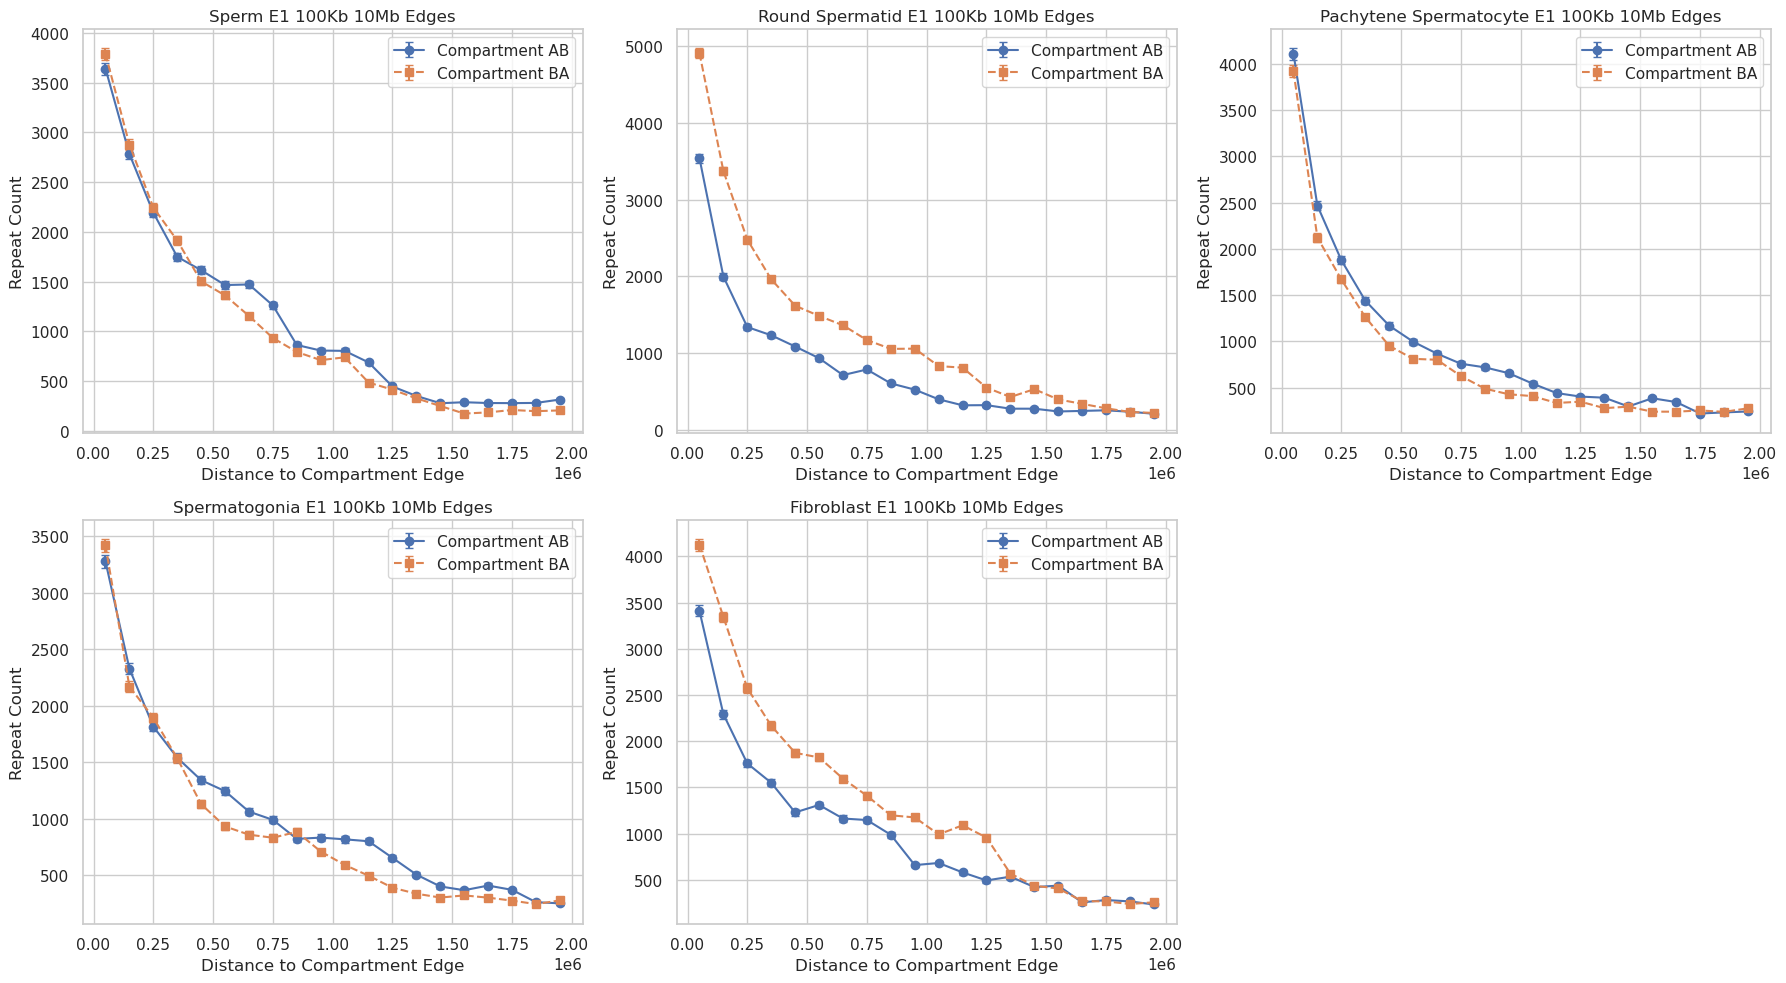

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Plot settings
# num_bins = 20
# max_dist = 2_000_000
# bins = np.linspace(0, max_dist, num_bins + 1)
# bin_centers = 0.5 * (bins[:-1] + bins[1:])

# def bin_absmid_with_error(absmid_values, bins):
#     counts, _ = np.histogram(absmid_values, bins=bins)
#     errors = np.sqrt(counts)
#     return counts, errors

# # Prepare plot grid
# fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# axes = axes.flatten()

# # Loop through samples
# for idx, (sample, pair) in enumerate(remapped_data.items()):
#     A_df = pair["A"]
#     B_df = pair["B"]

#     # Bin 'absmid'
#     counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins)
#     counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins)

#     ax = axes[idx]
#     ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3, label='Compartment AB')
#     ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3, label='Compartment BA')
#     ax.set_title(sample.replace("_", " ").title())
#     ax.set_xlabel("Distance to Compartment Edge")
#     ax.set_ylabel("Repeat Count")
#     ax.grid(True)
#     ax.legend()

# # Hide unused subplot (slot 6)
# if len(remapped_data) < len(axes):
#     for i in range(len(remapped_data), len(axes)):
#         axes[i].axis('off')

# plt.tight_layout()
# plt.show()

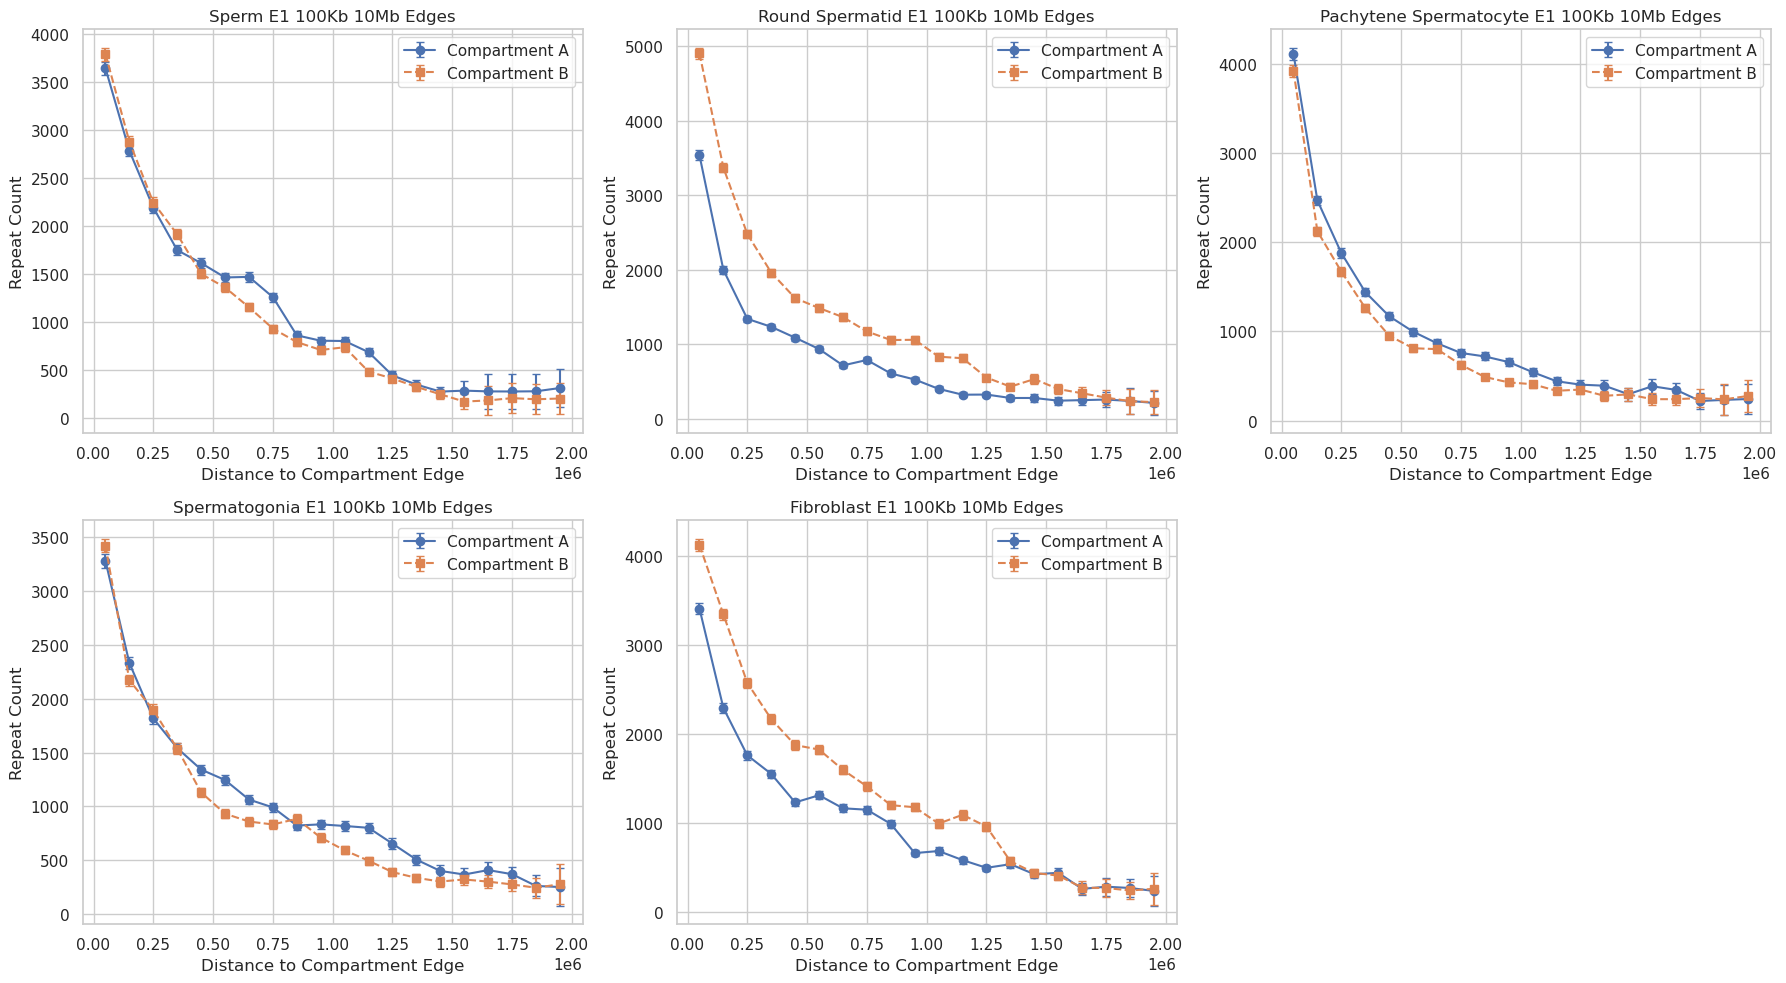

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_absmid_with_error(absmid_values, bins, edge_reverse_cumulative):
    counts, _ = np.histogram(absmid_values, bins=bins)

    # Regular Poisson errors
    errors = np.sqrt(counts)

    # Avoid division by zero
    edge_reverse_cumulative = np.where(edge_reverse_cumulative == 0, 1, edge_reverse_cumulative)

    # Adjust errors based on how many edges contribute to each bin
    adjusted_errors = errors * (1 + 10 / edge_reverse_cumulative)

    return counts, adjusted_errors



# Prepare plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plotting
for idx, (sample, pair) in enumerate(remapped_data.items()):
    A_df = pair["A"]
    B_df = pair["B"]
    # Get the actual edge DataFrame using the sample name
    edge_df = globals()[sample+ "_AB"]  # assumes sperm_e1_... etc. are loaded variables

    # Compute edge spacing reverse cumulative
    edges_counts, edges_reverse_cumulative = bin_half_distances(edge_df)
    counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins, edges_reverse_cumulative)
    counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins, edges_reverse_cumulative)

    ax = axes[idx]
    ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
    ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
    ax.set_title(sample.replace("_", " ").title())
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True)
    ax.legend()

# Hide unused subplot (slot 6)
if len(remapped_data) < len(axes):
    for i in range(len(remapped_data), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()

###  Analysis Summary: Simple Repeats Around Compartment Edges

In this analysis, we examined the distribution of simple repeats relative to **compartment boundaries**, specifically focusing on **edges where transitions occur between A and B compartments**. Instead of accounting for the compartment the region originated from, we categorized each edge based on the *target compartment*:

- **A edges**: Transitions into A compartments (from B → A)
- **B edges**: Transitions into B compartments (from A → B)

We calculated the absolute distance of each repeat from the edge and compared the density of repeats near A vs. B edges across five cell types.

---

####  Key Observations:

1. **Round Spermatids & Fibroblasts**  
   - These cell types exhibit a clear enrichment of simple repeats near **B edges** (into B compartments).
   - This enrichment is consistent from the edge out to ~2 Mb.
   - Repeat counts are significantly higher near B edges than A edges across all distances.

2. **Sperm, Spermatogonia, & Pachytene Spermatocytes**  
   - These show a less pronounced difference between A and B edges.
   - Some enrichment patterns are present but are subtler and more variable compared to round spermatids and fibroblasts.

3. **Overall Distance Effect**  
   - Across all samples, repeat density is **highest closest to the compartment edge**.
   - Near 0 bp (directly at the edge), counts often range from **3,000–4,000**.
   - By 2 Mb from the edge, repeat counts typically drop to **below 500**.
   - This supports a general trend that simple repeats are concentrated near compartment boundaries, regardless of compartment identity.

---

#### Conclusion:

These findings suggest that **simple repeats are enriched near compartment edges**, with stronger enrichment near B edges in specific cell types like round spermatids and fibroblasts. This may indicate functional or structural roles for repeat elements at the interface of chromatin compartment transitions.


## Nested repeat

In [60]:
#INPORT repeats 
#header found here= https://genome.ucsc.edu/cgi-bin/hgTables?db=hg38&hgta_group=rep&hgta_track=nestedRepeats&hgta_table=nestedRepeats&hgta_doSchema=describe+table+schema
columns = [
    "bin", "chrom", "chromStart", "chromEnd", "name", "score", "strand",
    "thickStart", "thickEnd", "reserved", "blockCount", "blockSizes",
    "chromStarts", "strandRep", "repLeft", "repClass", "repFamily"
]

repeats = pd.read_csv("/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/nestedRepeats.txt", sep='\t', header=None, names=columns)

# View first few rows
print(repeats.head())
df_nested_repeats = repeats[repeats['chrom'] == 'chrX'][['chrom', 'chromStart', 'chromEnd']].rename(
    columns={'chromStart': 'start', 'chromEnd': 'end'}
)

   bin chrom  chromStart  chromEnd     name  score strand  thickStart  \
0  585  chr1        3116      3467  AluYRa1    856      +        3116   
1  585  chr1        3926      7211    L1PA7    748      +        3926   
2  585  chr1       13937     14502  L1ME3Cz    184      +       13937   
3  585  chr1       17217     20642    L1MB2    319      +       17217   
4  585  chr1       18677     19608    AluJb    606      -       18677   

   thickEnd  reserved  blockCount          blockSizes            chromStarts  \
0      3467         0           2             301,19,                 0,332,   
1      7211         0           2          1116,1857,                0,1428,   
2     14502         0           2            329,136,                 0,429,   
3     20642         0           5  113,564,72,45,452,  0,469,1337,2635,2973,   
4     19608         0           2             77,238,                 0,693,   

    strandRep  repLeft repClass repFamily  
0        +,+,        3     SINE     

In [61]:
ab_dfs = {name: obj for name, obj in globals().items()
          if name.endswith('_AB') and isinstance(obj, pd.DataFrame)}
remapped_nested_data = {}

for name, df_anchor in ab_dfs.items():
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = plot_repeat_density_vs_compartment_edge(df_nested_repeats, df_anchor)
        remapped_nested_data[name.replace('_AB', '')] = {"A": A_value, "B": B_value}
        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")



Running on: sperm_e1_100kb_10Mb_edges_AB
  A_value: (15163, 12), B_value: (15733, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
  A_value: (16749, 12), B_value: (13920, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (17407, 12), B_value: (11859, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (12920, 12), B_value: (17398, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (19177, 12), B_value: (12545, 12)


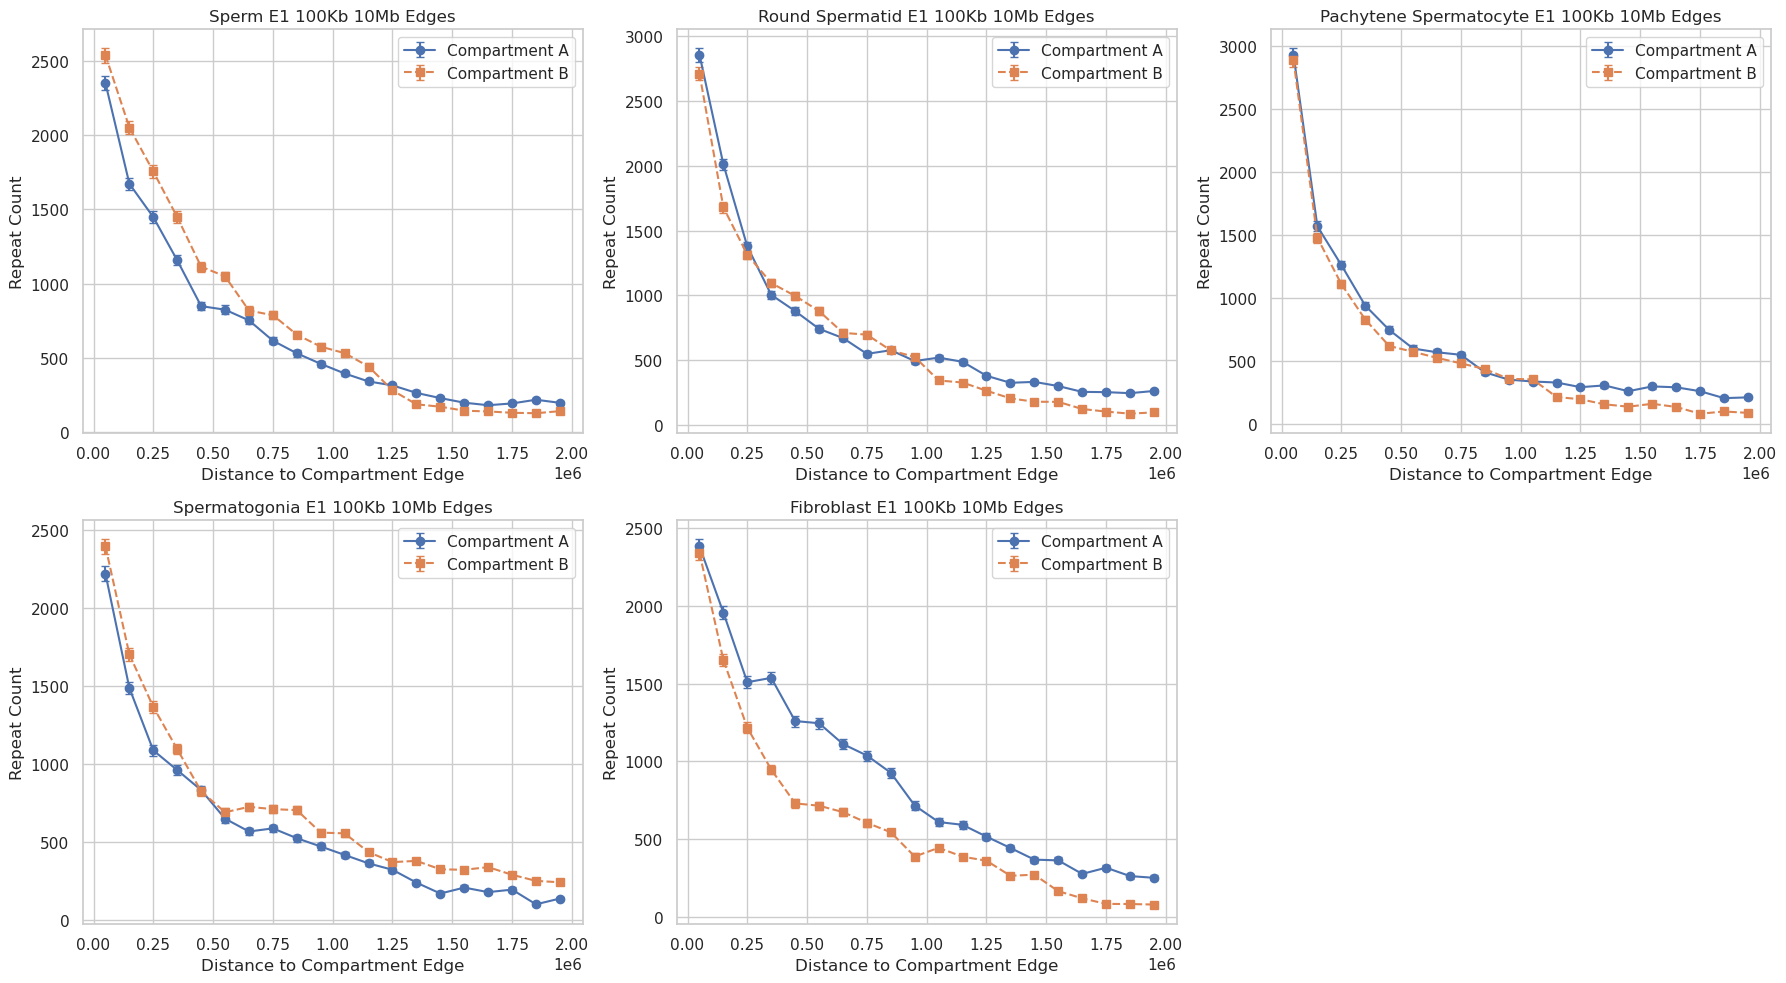

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Plot settings
# num_bins = 20
# max_dist = 2_000_000
# bins = np.linspace(0, max_dist, num_bins + 1)
# bin_centers = 0.5 * (bins[:-1] + bins[1:])

# def bin_absmid_with_error(absmid_values, bins):
#     counts, _ = np.histogram(absmid_values, bins=bins)
#     errors = np.sqrt(counts)
#     return counts, errors

# # Prepare plot grid
# fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# axes = axes.flatten()

# # Loop through samples
# for idx, (sample, pair) in enumerate(remapped_nested_data.items()):
#     A_df = pair["A"]
#     B_df = pair["B"]

#     # Bin 'absmid'
#     counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins)
#     counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins)

#     ax = axes[idx]
#     ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
#     ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
#     ax.set_title(sample.replace("_", " ").title())
#     ax.set_xlabel("Distance to Compartment Edge")
#     ax.set_ylabel("Repeat Count")
#     ax.grid(True)
#     ax.legend()

# # Hide unused subplot (slot 6)
# if len(remapped_nested_data) < len(axes):
#     for i in range(len(remapped_nested_data), len(axes)):
#         axes[i].axis('off')

# plt.tight_layout()
# plt.show()

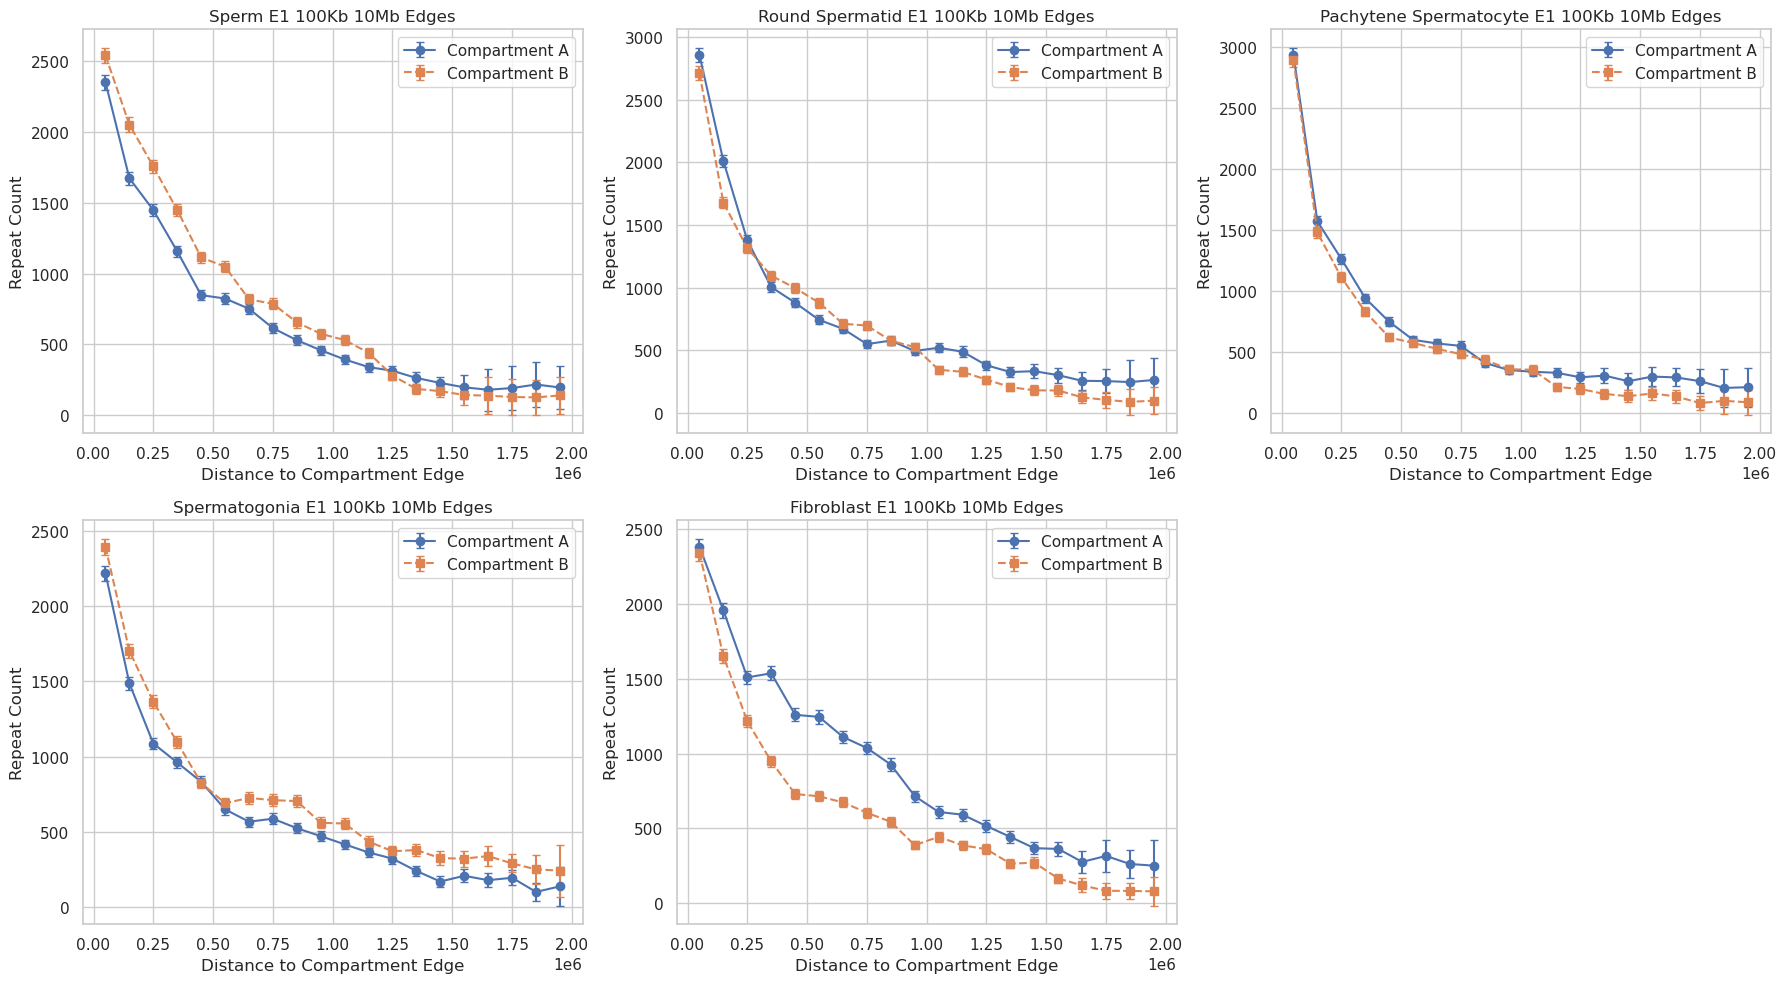

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_absmid_with_error(absmid_values, bins, edge_reverse_cumulative):
    counts, _ = np.histogram(absmid_values, bins=bins)

    # Regular Poisson errors
    errors = np.sqrt(counts)

    # Avoid division by zero
    edge_reverse_cumulative = np.where(edge_reverse_cumulative == 0, 1, edge_reverse_cumulative)

    # Adjust errors based on how many edges contribute to each bin
    adjusted_errors = errors * (1 + 10 / edge_reverse_cumulative)

    return counts, adjusted_errors



# Prepare plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plotting
for idx, (sample, pair) in enumerate(remapped_nested_data.items()):
    A_df = pair["A"]
    B_df = pair["B"]
    # Get the actual edge DataFrame using the sample name
    edge_df = globals()[sample+ "_AB"]  # assumes sperm_e1_... etc. are loaded variables

    # Compute edge spacing reverse cumulative
    edges_counts, edges_reverse_cumulative = bin_half_distances(edge_df)
    counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins, edges_reverse_cumulative)
    counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins, edges_reverse_cumulative)

    ax = axes[idx]
    ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
    ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
    ax.set_title(sample.replace("_", " ").title())
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True)
    ax.legend()

# Hide unused subplot (slot 6)
if len(remapped_nested_data) < len(axes):
    for i in range(len(remapped_nested_data), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [64]:

ab_dfs = {name: obj for name, obj in globals().items()
          if name.endswith('_AB') and isinstance(obj, pd.DataFrame)}
remapped_nested_nofilter_data = {}

for name, df_anchor in ab_dfs.items():
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = remapping_no_filter_compartment(df_nested_repeats, df_anchor)
        remapped_nested_nofilter_data[name.replace('_AB', '')] = {"A": A_value, "B": B_value}
        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")


Running on: sperm_e1_100kb_10Mb_edges_AB


  A_value: (15505, 12), B_value: (15393, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
  A_value: (12149, 12), B_value: (18524, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (15831, 12), B_value: (13436, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (15784, 12), B_value: (14535, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (14349, 12), B_value: (17374, 12)


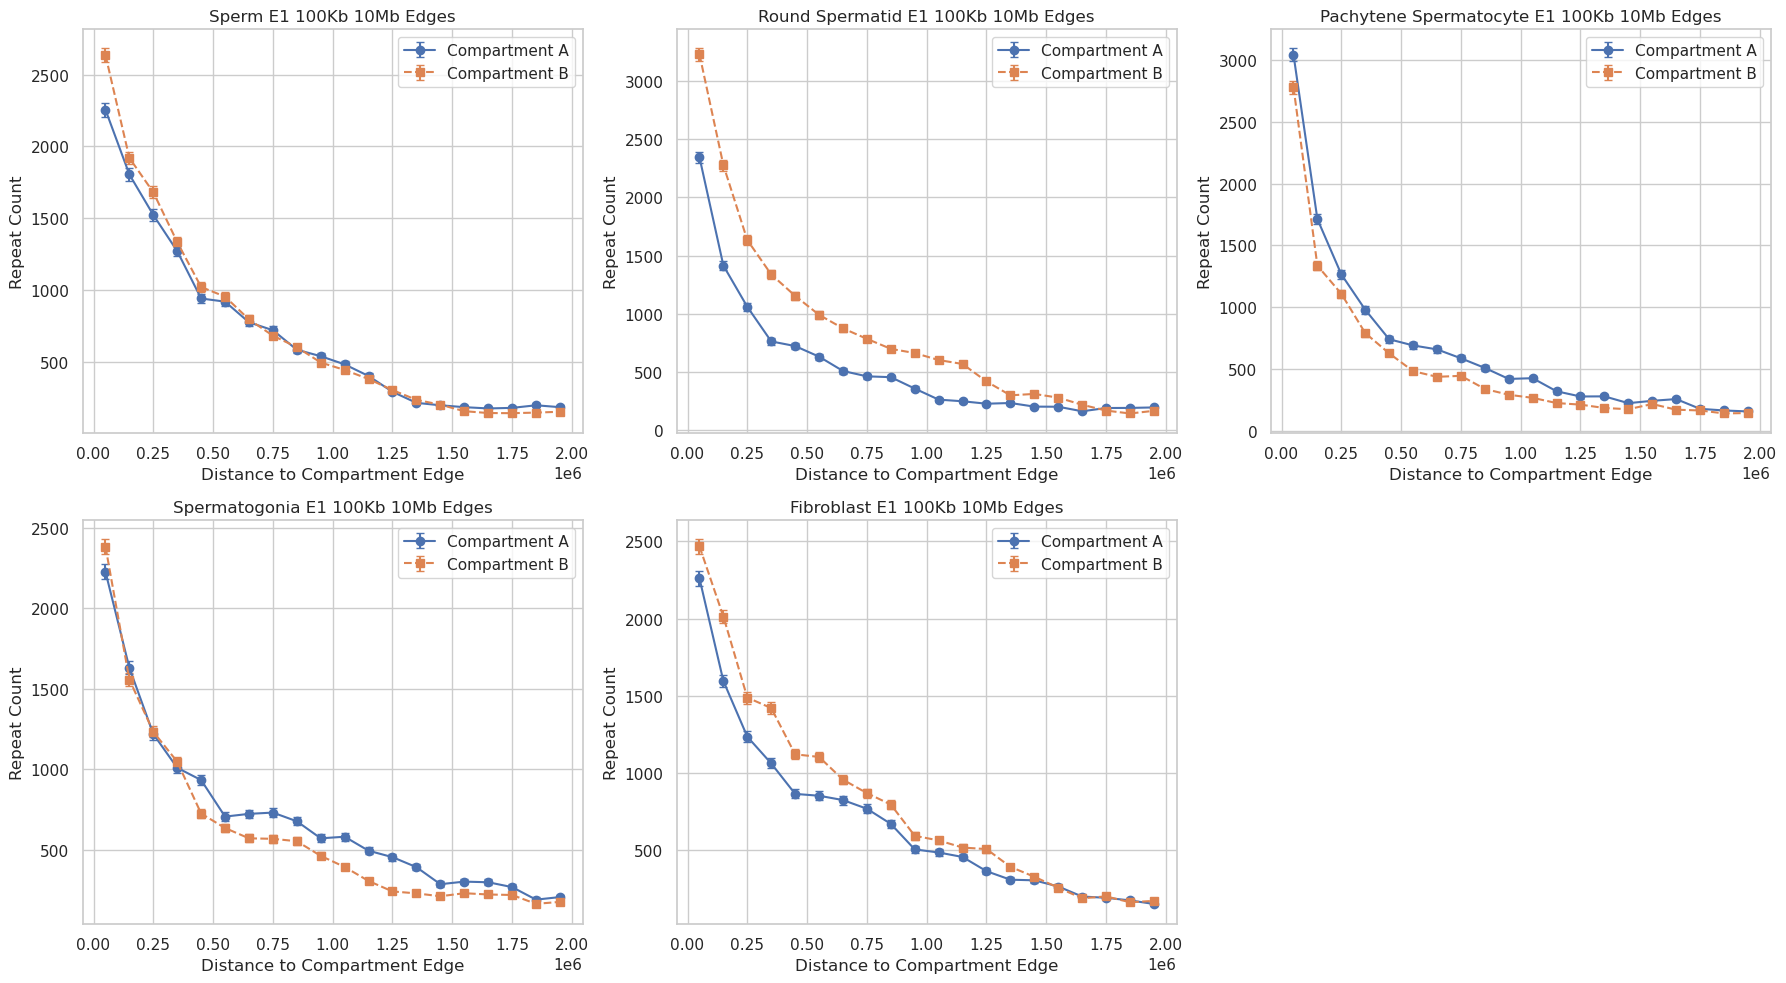

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Plot settings
# num_bins = 20
# max_dist = 2_000_000
# bins = np.linspace(0, max_dist, num_bins + 1)
# bin_centers = 0.5 * (bins[:-1] + bins[1:])

# def bin_absmid_with_error(absmid_values, bins):
#     counts, _ = np.histogram(absmid_values, bins=bins)
#     errors = np.sqrt(counts)
#     return counts, errors

# # Prepare plot grid
# fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# axes = axes.flatten()

# # Loop through samples
# for idx, (sample, pair) in enumerate(remapped_nested_nofilter_data.items()):
#     A_df = pair["A"]
#     B_df = pair["B"]

#     # Bin 'absmid'
#     counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins)
#     counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins)

#     ax = axes[idx]
#     ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
#     ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
#     ax.set_title(sample.replace("_", " ").title())
#     ax.set_xlabel("Distance to Compartment Edge")
#     ax.set_ylabel("Repeat Count")
#     ax.grid(True)
#     ax.legend()

# # Hide unused subplot (slot 6)
# if len(remapped_nested_nofilter_data) < len(axes):
#     for i in range(len(remapped_nested_nofilter_data), len(axes)):
#         axes[i].axis('off')

# plt.tight_layout()
# plt.show()

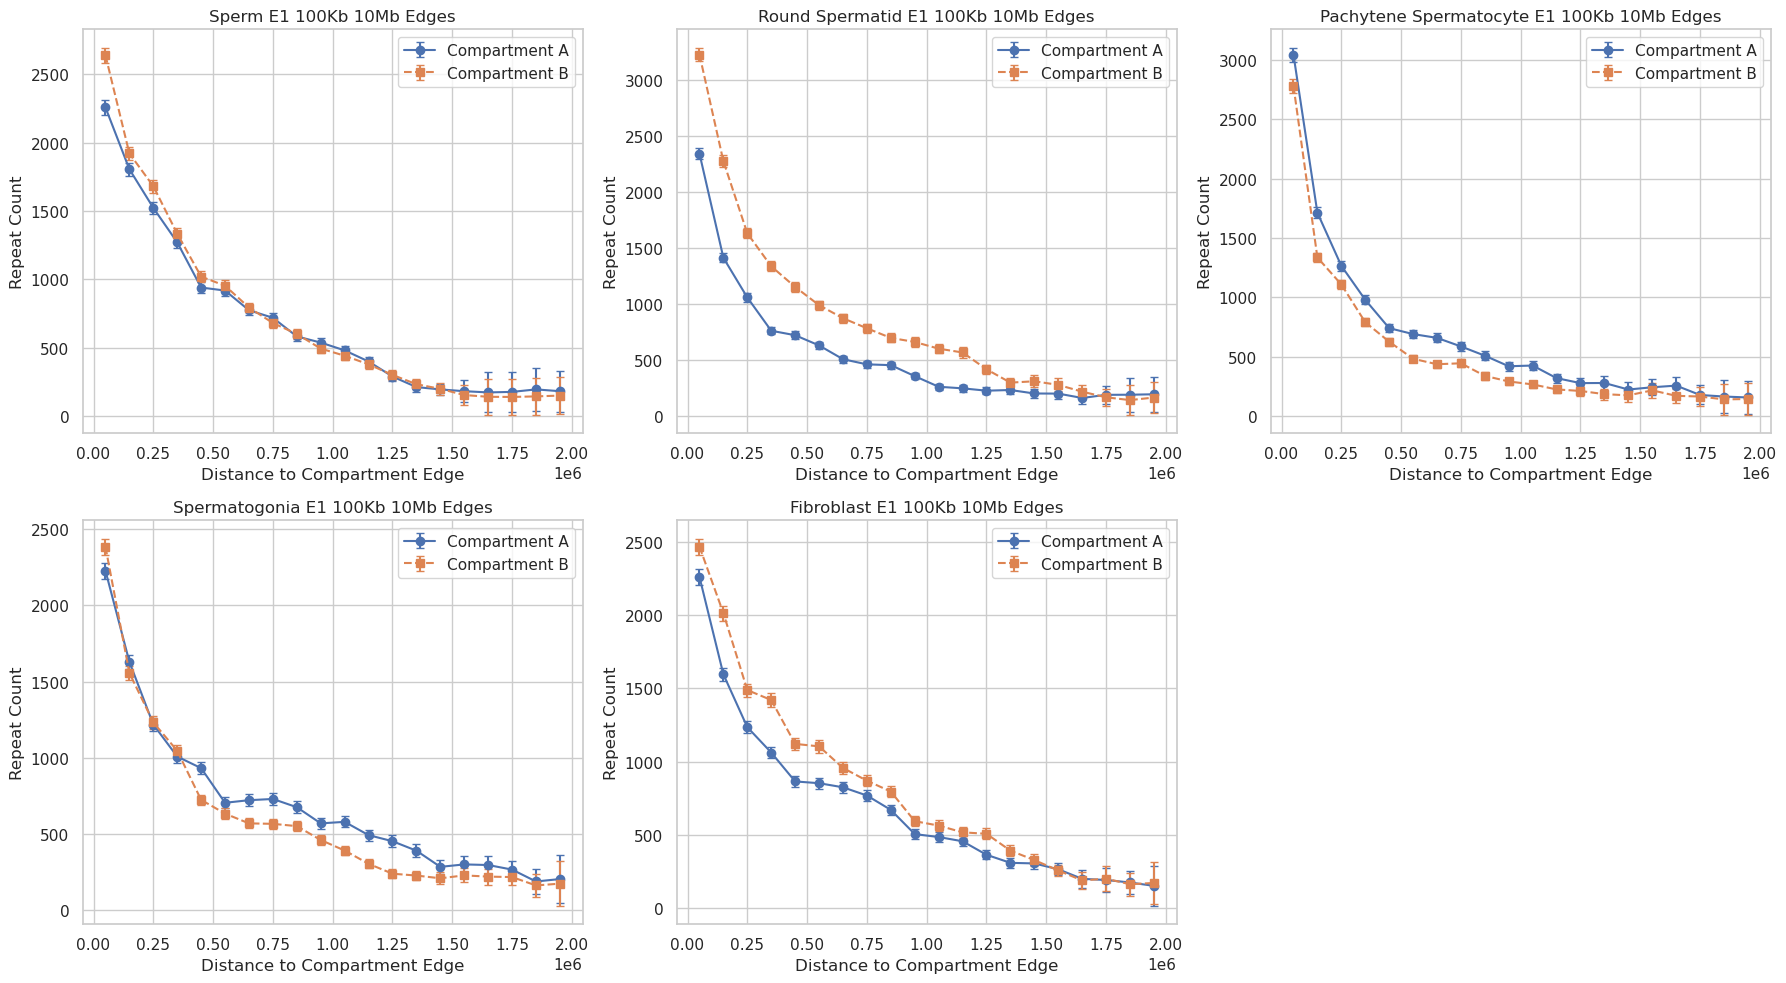

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_absmid_with_error(absmid_values, bins, edge_reverse_cumulative):
    counts, _ = np.histogram(absmid_values, bins=bins)

    # Regular Poisson errors
    errors = np.sqrt(counts)

    # Avoid division by zero
    edge_reverse_cumulative = np.where(edge_reverse_cumulative == 0, 1, edge_reverse_cumulative)

    # Adjust errors based on how many edges contribute to each bin
    adjusted_errors = errors * (1 + 10 / edge_reverse_cumulative)

    return counts, adjusted_errors



# Prepare plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plotting
for idx, (sample, pair) in enumerate(remapped_nested_nofilter_data.items()):
    A_df = pair["A"]
    B_df = pair["B"]
    # Get the actual edge DataFrame using the sample name
    edge_df = globals()[sample+ "_AB"]  # assumes sperm_e1_... etc. are loaded variables

    # Compute edge spacing reverse cumulative
    edges_counts, edges_reverse_cumulative = bin_half_distances(edge_df)
    counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins, edges_reverse_cumulative)
    counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins, edges_reverse_cumulative)

    ax = axes[idx]
    ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
    ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
    ax.set_title(sample.replace("_", " ").title())
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True)
    ax.legend()

# Hide unused subplot (slot 6)
if len(remapped_nested_nofilter_data) < len(axes):
    for i in range(len(remapped_nested_nofilter_data), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()

###  How Error Bars Are Calculated

The error bars in this plot are **not** confidence intervals like those automatically produced by Seaborn’s `pointplot()`.  
Instead, they are **Poisson error bars**, computed using the square root of the count in each bin.

This is appropriate for count data like ours, where each repeat is treated as an **independent event**.

---

###  Poisson Error Model

In a **Poisson process**, the standard deviation of the number of events in a bin is given by:

\[
\sigma = \sqrt{N}
\]

Where:
- \( N \) is the number of observed events (repeat counts) in a bin,
- \( \sigma \) represents the expected variability under the assumption that the events occur independently.

We apply this to each distance bin to visualize the **expected variance in repeat density**, without assuming repeated sampling or any bootstrapped distribution.

---

###  Code Snippet

```python
def bin_absmid_with_error(absmid_values, bins):
    counts, _ = np.histogram(absmid_values, bins=bins)
    errors = np.sqrt(counts)
    return counts, errors


## fixing error bars

In [69]:
import numpy as np

def bin_half_distances(comp, max_dist=2_000_000, bins=30):
    start = comp['start'].values
    # Compute half-distances between consecutive start positions
    half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]

    # Bin those distances
    bin_edges = np.linspace(0, max_dist, bins + 1)
    counts, _ = np.histogram(half_distances, bins=bin_edges)

    # Reverse cumulative sum — how many possible contributing edges for each bin
    reverse_cumulative_counts = np.cumsum(counts[::-1])[::-1]

    return counts, reverse_cumulative_counts


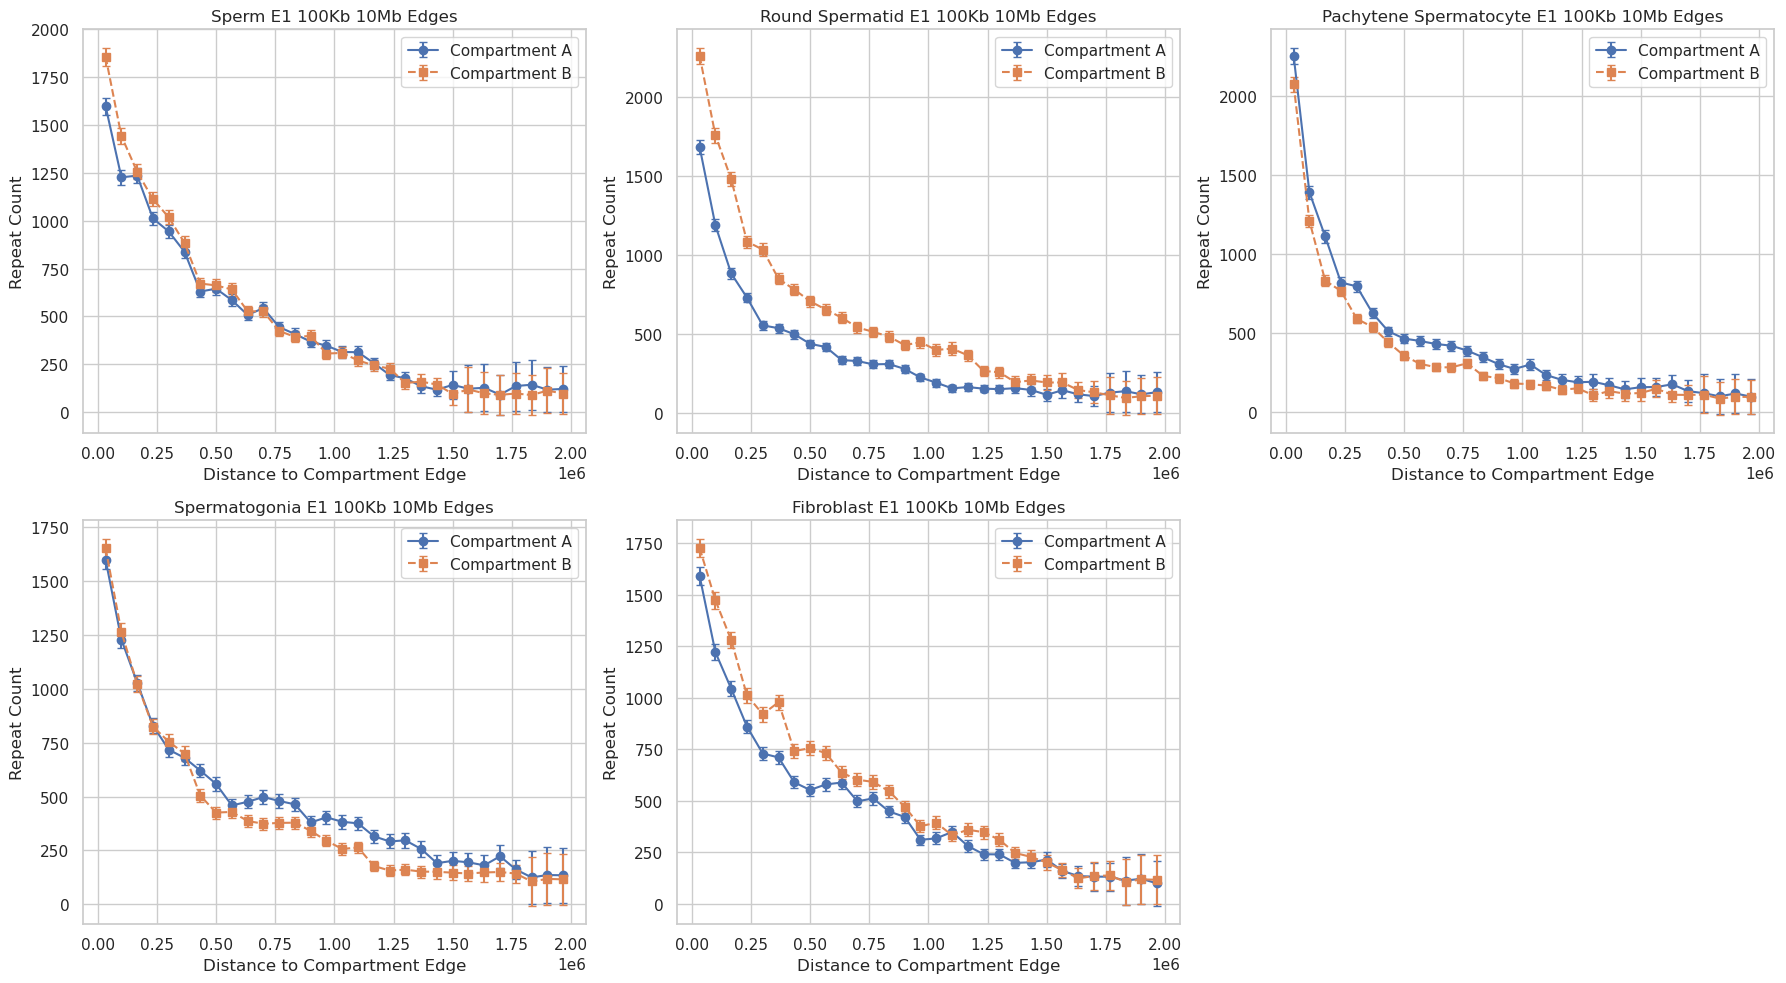

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
num_bins = 30
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_absmid_with_error(absmid_values, bins, edge_reverse_cumulative):
    counts, _ = np.histogram(absmid_values, bins=bins)

    # Regular Poisson errors
    errors = np.sqrt(counts)

    # Avoid division by zero
    edge_reverse_cumulative = np.where(edge_reverse_cumulative == 0, 1, edge_reverse_cumulative)

    # Adjust errors based on how many edges contribute to each bin
    adjusted_errors = errors * (1 + 10 / edge_reverse_cumulative)

    return counts, adjusted_errors



# Prepare plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plotting
for idx, (sample, pair) in enumerate(remapped_nested_nofilter_data.items()):
    A_df = pair["A"]
    B_df = pair["B"]
    # Get the actual edge DataFrame using the sample name
    edge_df = globals()[sample+ "_AB"]  # assumes sperm_e1_... etc. are loaded variables

    # Compute edge spacing reverse cumulative
    edges_counts, edges_reverse_cumulative = bin_half_distances(edge_df)
    counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins, edges_reverse_cumulative)
    counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins, edges_reverse_cumulative)

    ax = axes[idx]
    ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
    ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
    ax.set_title(sample.replace("_", " ").title())
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True)
    ax.legend()

# Hide unused subplot (slot 6)
if len(remapped_nested_nofilter_data) < len(axes):
    for i in range(len(remapped_nested_nofilter_data), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()

[119  92  78  75  60  53  49  39  38  37]
(30,)


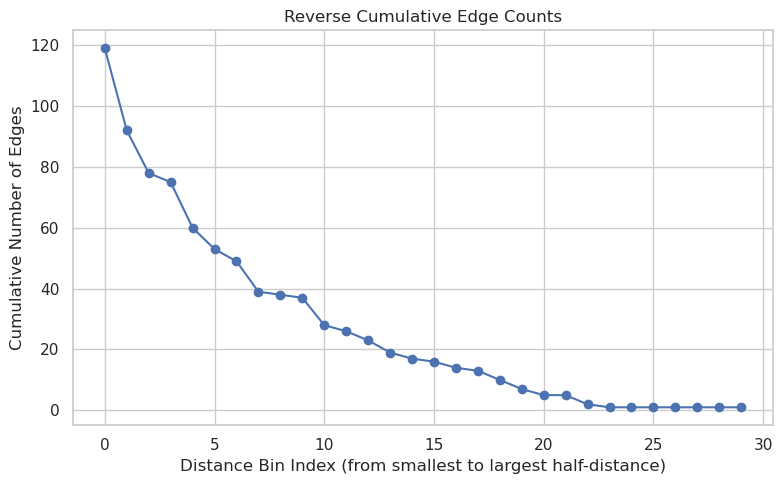

In [77]:
half_distance,reverse_cumulative  = bin_half_distances(sperm_e1_100kb_10Mb_edges_AB)
print(reverse_cumulative [:10])
print(reverse_cumulative.shape)

plt.figure(figsize=(8, 5))
plt.plot(reverse_cumulative, marker='o')
plt.title("Reverse Cumulative Edge Counts")
plt.xlabel("Distance Bin Index (from smallest to largest half-distance)")
plt.ylabel("Cumulative Number of Edges")
plt.grid(True)
plt.tight_layout()
plt.show()


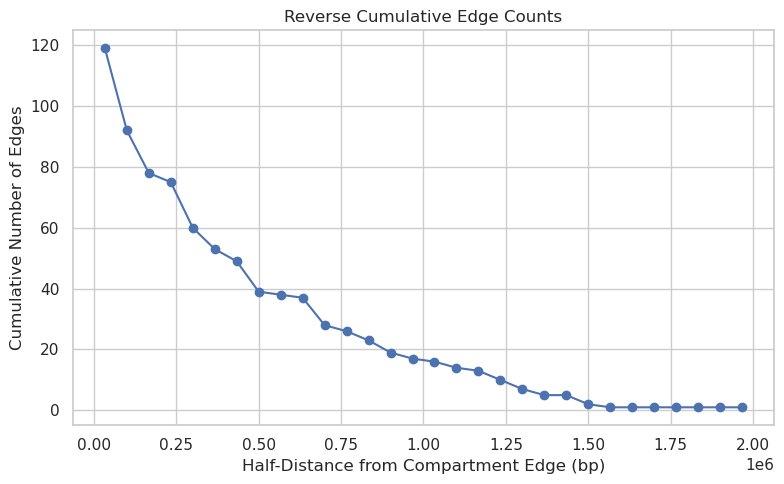

In [78]:
max_dist = 2_000_000
num_bins = 30
bin_edges = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, reverse_cumulative, marker='o')
plt.title("Reverse Cumulative Edge Counts")
plt.xlabel("Half-Distance from Compartment Edge (bp)")
plt.ylabel("Cumulative Number of Edges")
plt.grid(True)
plt.tight_layout()
plt.show()


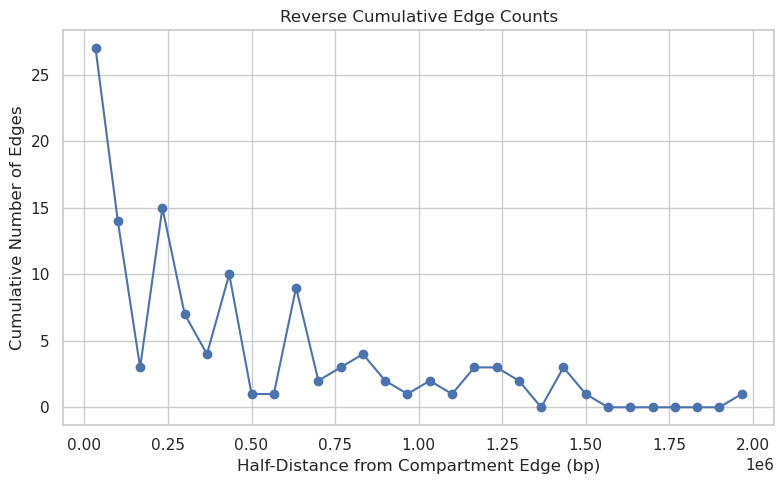

In [79]:
max_dist = 2_000_000
num_bins = 30
bin_edges = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, half_distance, marker='o')
plt.title("Reverse Cumulative Edge Counts")
plt.xlabel("Half-Distance from Compartment Edge (bp)")
plt.ylabel("Cumulative Number of Edges")
plt.grid(True)
plt.tight_layout()
plt.show()

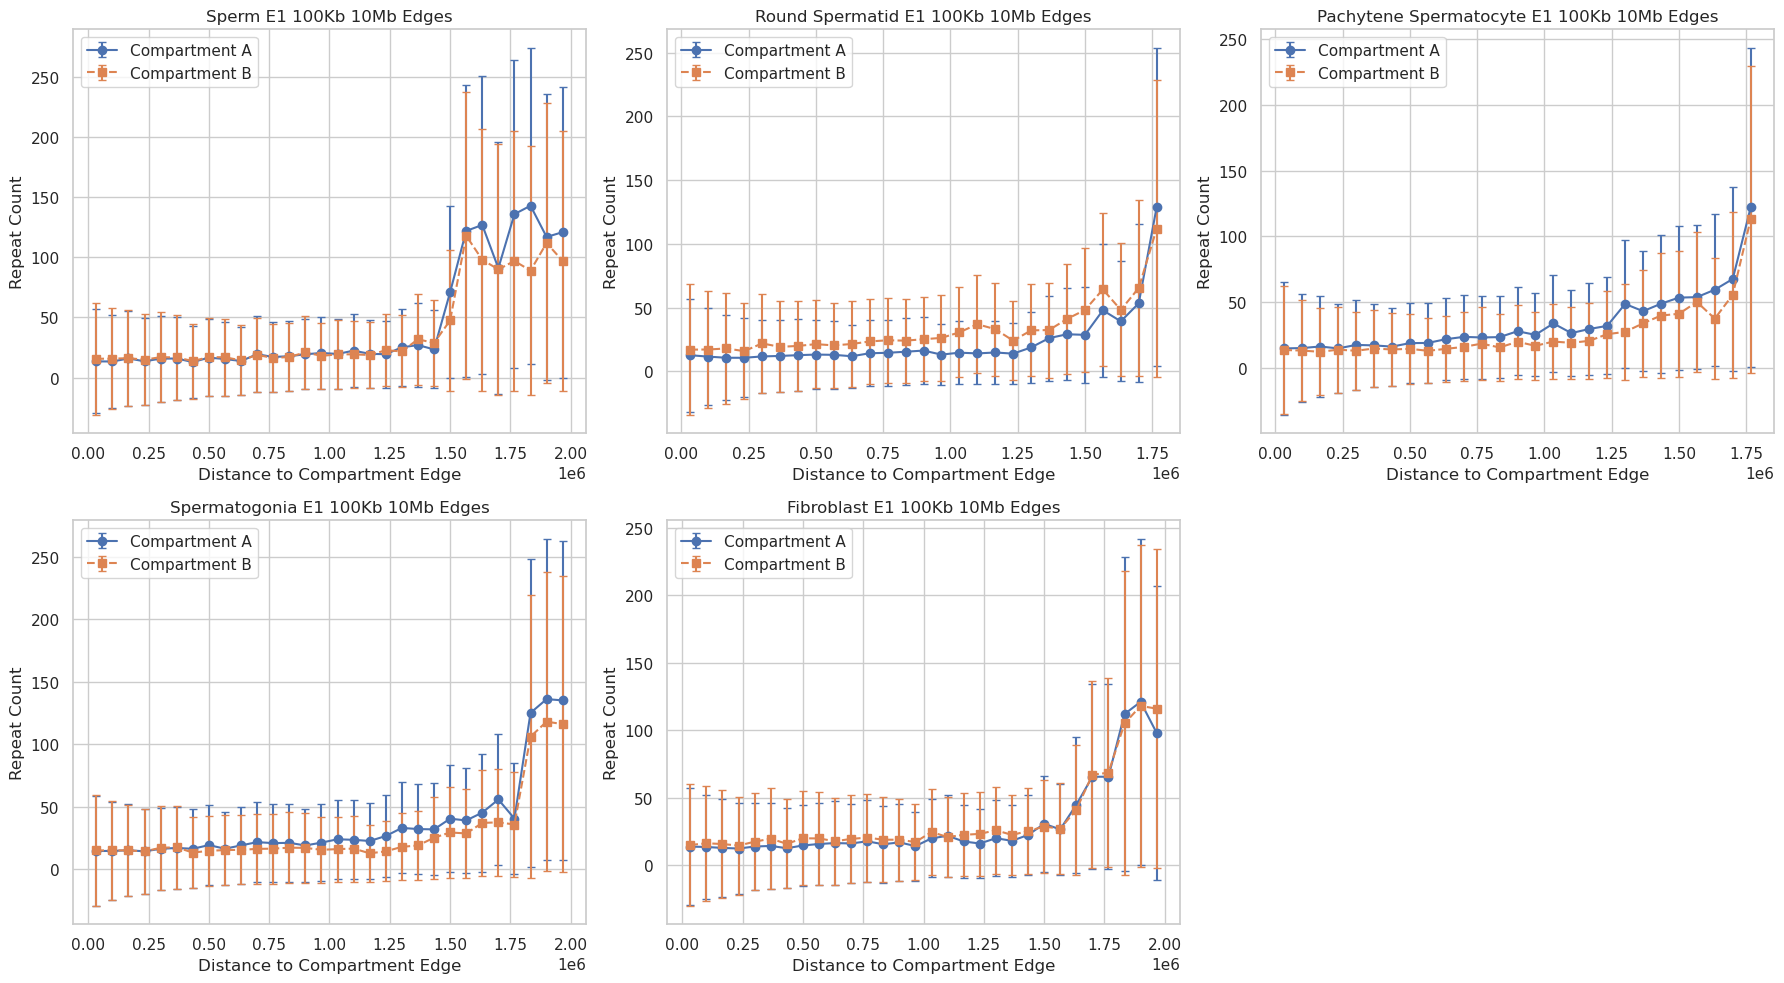

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
num_bins = 30
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_absmid_with_error(absmid_values, bins, edge_reverse_cumulative):
    counts, _ = np.histogram(absmid_values, bins=bins)

    # Regular Poisson errors
    errors = np.sqrt(counts)

    # Avoid division by zero
    edge_reverse_cumulative = np.where(edge_reverse_cumulative == 0, 1, edge_reverse_cumulative)

    # Adjust errors based on how many edges contribute to each bin
    adjusted_errors = errors * (1 + 10 / edge_reverse_cumulative)

    return counts, adjusted_errors



# Prepare plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plotting
for idx, (sample, pair) in enumerate(remapped_nested_nofilter_data.items()):
    A_df = pair["A"]
    B_df = pair["B"]
    # Get the actual edge DataFrame using the sample name
    edge_df = globals()[sample+ "_AB"]  # assumes sperm_e1_... etc. are loaded variables

    # Compute edge spacing reverse cumulative
    edges_counts, edges_reverse_cumulative = bin_half_distances(edge_df)
    counts_A, raw_errors_A  = bin_absmid_with_error(A_df['absmid'].dropna(), bins, edges_reverse_cumulative)
    counts_B, raw_errors_B  = bin_absmid_with_error(B_df['absmid'].dropna(), bins, edges_reverse_cumulative)

    # Normalize by reverse cumulative (avoid division by zero)
    norm_reverse_cum = np.where(edges_reverse_cumulative == 0, np.nan, edges_reverse_cumulative)

    norm_counts_A = counts_A / norm_reverse_cum
    norm_counts_B = counts_B / norm_reverse_cum
    norm_errors_A = raw_errors_A / norm_reverse_cum
    norm_errors_B = raw_errors_B / norm_reverse_cum

    ax = axes[idx]
    ax.errorbar(bin_centers, norm_counts_A, yerr=raw_errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
    ax.errorbar(bin_centers, norm_counts_B, yerr=raw_errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
    ax.set_title(sample.replace("_", " ").title())
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True)
    ax.legend()

# Hide unused subplot (slot 6)
if len(remapped_nested_nofilter_data) < len(axes):
    for i in range(len(remapped_nested_nofilter_data), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()

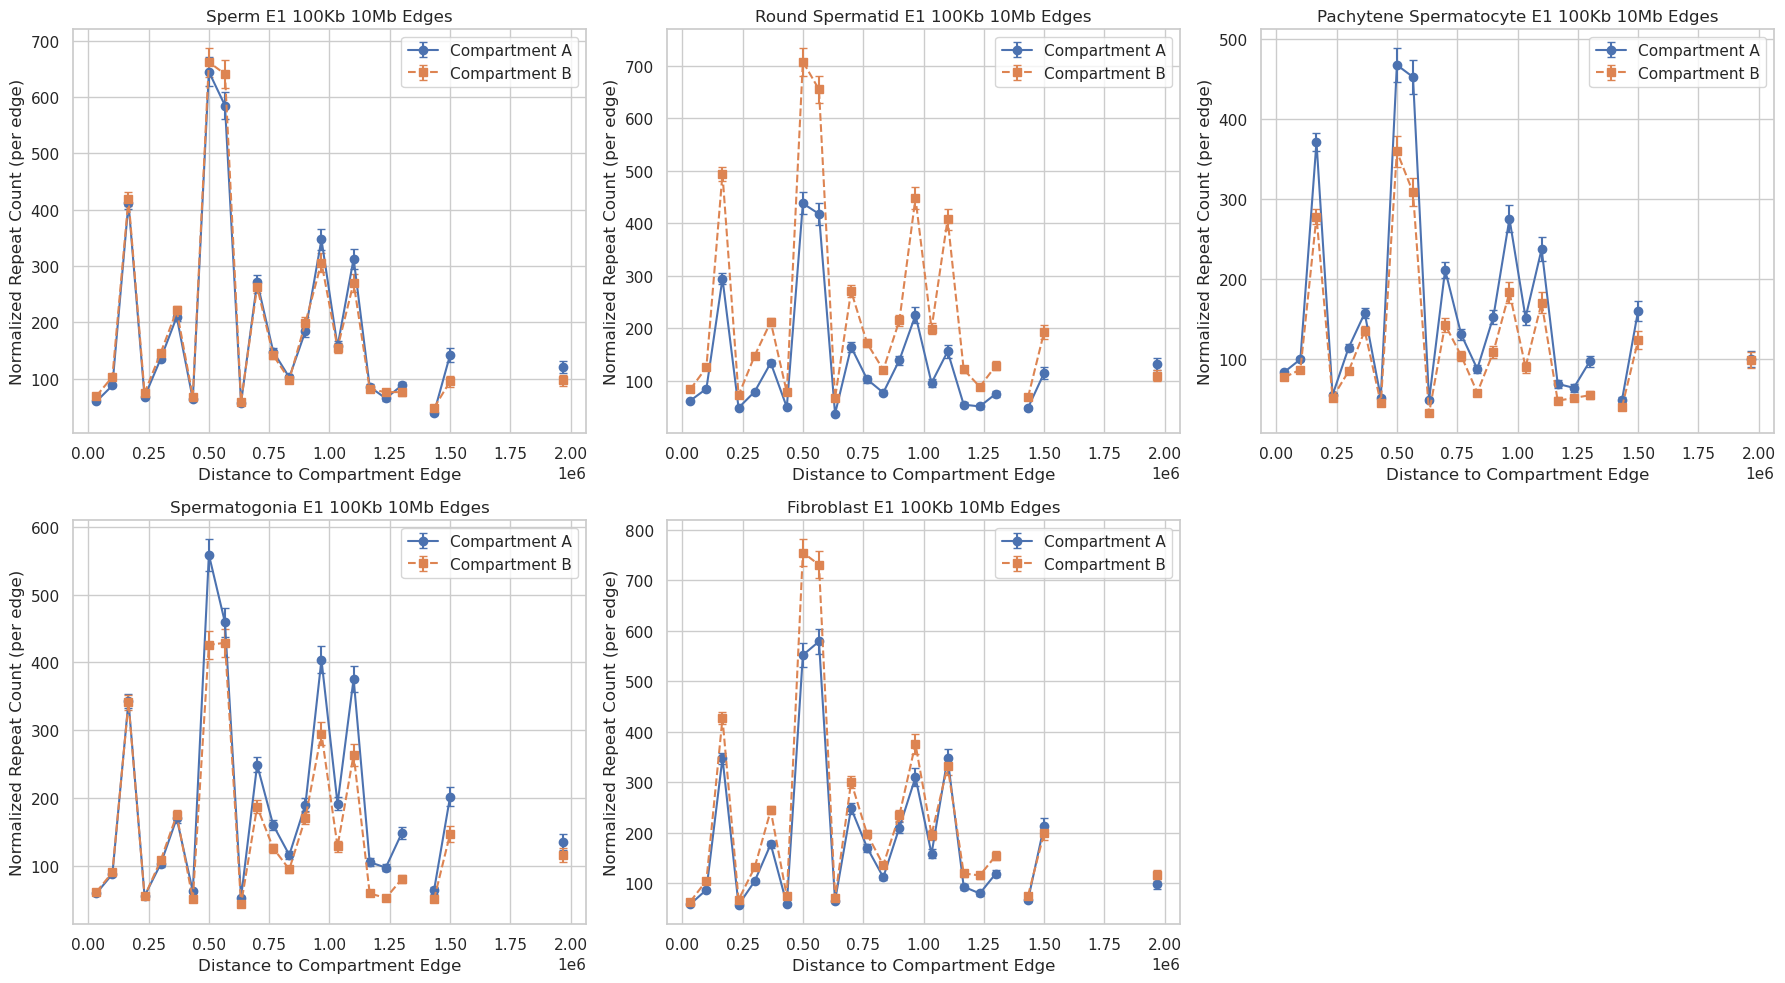

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
num_bins = 30
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_absmid_with_error(absmid_values, bins):
    counts, _ = np.histogram(absmid_values, bins=bins)
    errors = np.sqrt(counts)  # Poisson errors
    return counts, errors

# Load or calculate your half_distance (should match bin_centers length)
# Assuming you have it precomputed already, like:
# half_distance = compute_reverse_cumulative(...)  # or loaded from somewhere

# Prevent division by zero
safe_half_distance = np.where(half_distance == 0, np.nan, half_distance)

# Prepare plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plotting
for idx, (sample, pair) in enumerate(remapped_nested_nofilter_data.items()):
    A_df = pair["A"]
    B_df = pair["B"]
    
    counts_A, raw_errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins)
    counts_B, raw_errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins)

    # Normalize counts and errors by reverse cumulative edges
    norm_counts_A = counts_A / safe_half_distance
    norm_counts_B = counts_B / safe_half_distance
    norm_errors_A = raw_errors_A / safe_half_distance
    norm_errors_B = raw_errors_B / safe_half_distance

    ax = axes[idx]
    ax.errorbar(bin_centers, norm_counts_A, yerr=norm_errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
    ax.errorbar(bin_centers, norm_counts_B, yerr=norm_errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
    ax.set_title(sample.replace("_", " ").title())
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Normalized Repeat Count (per edge)")
    ax.grid(True)
    ax.legend()

# Hide unused subplot slots
if len(remapped_nested_nofilter_data) < len(axes):
    for i in range(len(remapped_nested_nofilter_data), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()


remapped_nested_data

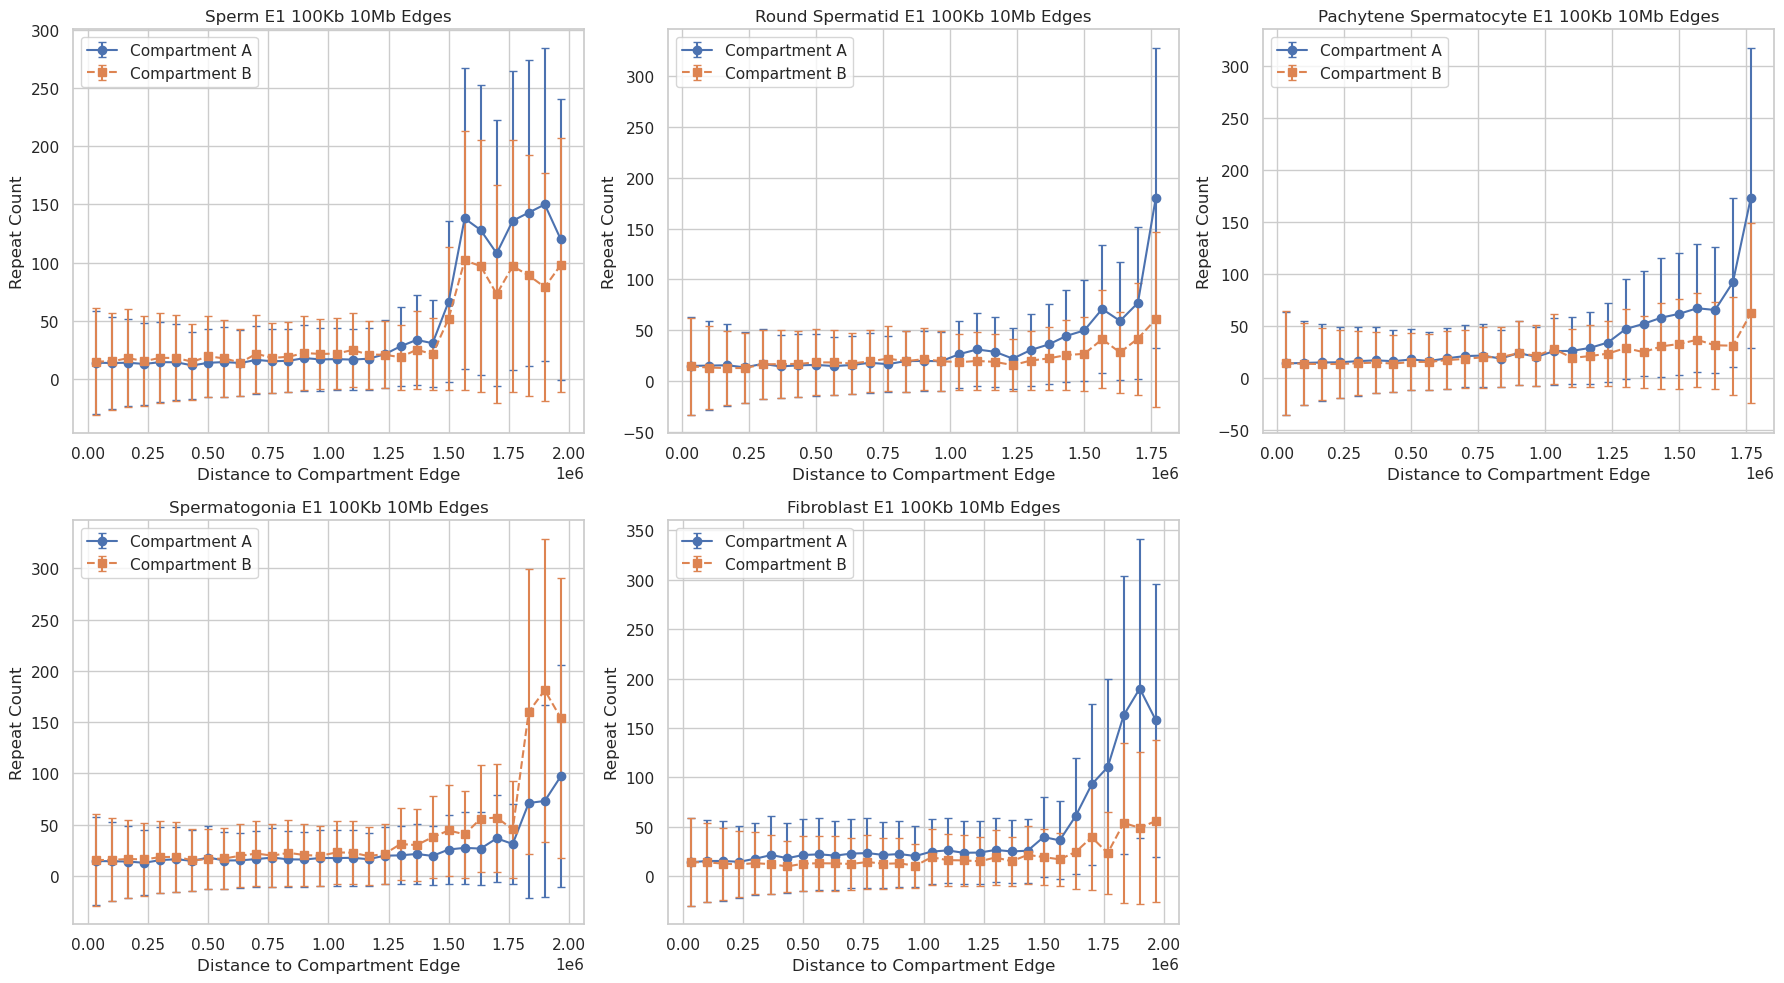

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
num_bins = 30
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_absmid_with_error(absmid_values, bins, edge_reverse_cumulative):
    counts, _ = np.histogram(absmid_values, bins=bins)

    # Regular Poisson errors
    errors = np.sqrt(counts)

    # Avoid division by zero
    edge_reverse_cumulative = np.where(edge_reverse_cumulative == 0, 1, edge_reverse_cumulative)

    # Adjust errors based on how many edges contribute to each bin
    adjusted_errors = errors * (1 + 10 / edge_reverse_cumulative)

    return counts, adjusted_errors



# Prepare plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plotting
for idx, (sample, pair) in enumerate(remapped_nested_data.items()):
    A_df = pair["A"]
    B_df = pair["B"]
    # Get the actual edge DataFrame using the sample name
    edge_df = globals()[sample+ "_AB"]  # assumes sperm_e1_... etc. are loaded variables

    # Compute edge spacing reverse cumulative
    edges_counts, edges_reverse_cumulative = bin_half_distances(edge_df)
    counts_A, raw_errors_A  = bin_absmid_with_error(A_df['absmid'].dropna(), bins, edges_reverse_cumulative)
    counts_B, raw_errors_B  = bin_absmid_with_error(B_df['absmid'].dropna(), bins, edges_reverse_cumulative)

    # Normalize by reverse cumulative (avoid division by zero)
    norm_reverse_cum = np.where(edges_reverse_cumulative == 0, np.nan, edges_reverse_cumulative)

    norm_counts_A = counts_A / norm_reverse_cum
    norm_counts_B = counts_B / norm_reverse_cum
    norm_errors_A = raw_errors_A / norm_reverse_cum
    norm_errors_B = raw_errors_B / norm_reverse_cum

    ax = axes[idx]
    ax.errorbar(bin_centers, norm_counts_A, yerr=raw_errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
    ax.errorbar(bin_centers, norm_counts_B, yerr=raw_errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
    ax.set_title(sample.replace("_", " ").title())
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True)
    ax.legend()

# Hide unused subplot (slot 6)
if len(remapped_nested_data) < len(axes):
    for i in range(len(remapped_nested_data), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()